# 🌍 PO_64 Project RichterX: Earthquake Pattern Analysis & Magnitude Prediction  
**Internship Project Title:** Earthquake Pattern Analysis  
**Intern:** Hetal Patel Dholu  
**Organization:** Outsource360


---
## Objective
Analyze earthquake datasets to identify patterns in magnitude, depth, time, and location, and to derive insights that can contribute to seismic hazard understanding and preparedness.


In [127]:
#importing necessary Libraries

In [199]:
# ===============================
# Core Libraries
# ===============================
import os
import time
import warnings
from datetime import datetime, timedelta, date
warnings.filterwarnings("ignore")

# ===============================
# Data Handling & Computation
# ===============================
import numpy as np
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# ===============================
# Statistics & Spatial Analysis
# ===============================
from scipy.stats import zscore
from scipy.spatial import KDTree
from statsmodels.tsa.arima.model import ARIMA

# ===============================
# Machine Learning & Preprocessing
# ===============================
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier
)
from sklearn.cluster import KMeans, DBSCAN

# ===============================
# Geospatial Libraries
# ===============================
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterstats import point_query

# ===============================
# Visualization Libraries
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ===============================
# Networking / APIs
# ===============================
import requests

# ===============================
# Serialization / Saving Models
# ===============================
import pickle
import gzip


In [129]:
# Fetching monthly/yearly Earthquake data from earthquake.usgs.gov
# ---------------- CONFIG ----------------
mode = "monthly"   # "monthly" or "yearly"
min_magnitude = 0 # set higher for yearly to reduce load
# -----------------------------------------
#Fetch earthquakes between start and end date from USGS
def fetch_quakes(start, end):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": start.strftime("%Y-%m-%d"),
        "endtime": end.strftime("%Y-%m-%d"),
        "minmagnitude": min_magnitude
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()["features"]

records = []

#Extract detailed earthquake fields
def extract_fields(f):
    prop, geom = f["properties"], f["geometry"]  # Separate properties and geometry
    return {
        'time': pd.to_datetime(prop['time'], unit='ms'), # Convert timestamp to datetime
        'latitude': geom['coordinates'][1],
        'longitude': geom['coordinates'][0],
        'depth': geom['coordinates'][2],
        'mag': prop['mag'],
        'magType': prop.get('magType'),
        'nst': prop.get('nst'),
        'gap': prop.get('gap'),
        'dmin': prop.get('dmin'),
        'rms': prop.get('rms'),
        'net': prop.get('net'),
        'id': prop.get('code'),
        'updated': pd.to_datetime(prop.get('updated'), unit='ms') if prop.get('updated') else None,
        'place': prop.get('place'),
        'type': prop.get('type'),
        'horizontalError': prop.get('horizontalError'),
        'depthError': prop.get('depthError'),
        'magError': prop.get('magError'),
        'magNst': prop.get('magNst'),
        'status': prop.get('status'),
        'locationSource': prop.get('locationSource'),
        'magSource': prop.get('magSource'),
    }

if mode == "monthly":
     # Fetch last 30 days of earthquake data directly from USGS feed
    url = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson'
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    features = data['features']
    # Extract fields from each earthquake and add to records
    for f in features:
        records.append(extract_fields(f))

elif mode == "yearly":
    # Fetch last 12 months of earthquake data in ~30-day chunks
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    current_start = start_date

    while current_start < end_date:
        current_end = min(current_start + timedelta(days=30), end_date)
        features = fetch_quakes(current_start, current_end)
        
        # Extract fields from each earthquake and add to records
        for f in features:
            records.append(extract_fields(f))
        
        current_start = current_end

# ---------------- Save to CSV ----------------
# Convert to DataFrame & Save
raw_eq_df = pd.DataFrame(records)
file_name = date.today().strftime("%Y_%m_%d") + f"_Earthquake_{mode.capitalize()}.csv"
raw_eq_df.to_csv(file_name, index=False)
print(f"Saved {len(raw_eq_df)} earthquakes to {file_name}")


Saved 9729 earthquakes to 2025_10_03_Earthquake_Monthly.csv


Here, the target variable is _**mag--magnitude**_

In [130]:
raw_eq_df.shape #Values vary as realtime data gets picked 

(9729, 22)

In [131]:
raw_eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9729 entries, 0 to 9728
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             9729 non-null   datetime64[ns]
 1   latitude         9729 non-null   float64       
 2   longitude        9729 non-null   float64       
 3   depth            9729 non-null   float64       
 4   mag              9728 non-null   float64       
 5   magType          9728 non-null   object        
 6   nst              8488 non-null   float64       
 7   gap              8488 non-null   float64       
 8   dmin             8488 non-null   float64       
 9   rms              9728 non-null   float64       
 10  net              9729 non-null   object        
 11  id               9729 non-null   object        
 12  updated          9729 non-null   datetime64[ns]
 13  place            9729 non-null   object        
 14  type             9729 non-null   object 

In [132]:
# Dataset Summary:
# We fetched 22 columns from the source.
# Observation: The following columns are always empty (0 non-null values):
# ['horizontalError', 'depthError', 'magError', 'magNst', 'locationSource', 'magSource']
# These provide no useful information for analysis and can be dropped safely.

In [133]:
raw_eq_df.sample(2)

time   latitude   longitude  depth   mag magType  \
8970 2025-09-05 11:03:31.399  35.613167  -98.044667   5.14  1.32      ml   
8045 2025-09-08 00:41:03.850  33.914667 -116.708333  14.44  0.92      ml   

       nst   gap     dmin   rms  ...                 updated  \
8970  57.0  55.0  0.15477  0.43  ... 2025-09-09 19:37:46.687   
8045  37.0  37.0  0.10970  0.15  ... 2025-09-08 00:44:29.895   

                            place        type horizontalError depthError  \
8970  6 km E of Calumet, Oklahoma  earthquake            None       None   
8045        7 km E of Cabazon, CA  earthquake            None       None   

     magError magNst     status locationSource magSource  
8970     None   None   reviewed           None      None  
8045     None   None  automatic           None      None  

[2 rows x 22 columns]

In [134]:
#check if there are missing values
print("Missing values check") 
for i in raw_eq_df.columns:
    print(i ,":",raw_eq_df[i].isnull().sum()*100/raw_eq_df.shape[0],"%")

Missing values check
time : 0.0 %
latitude : 0.0 %
longitude : 0.0 %
depth : 0.0 %
mag : 0.010278548668927948 %
magType : 0.010278548668927948 %
nst : 12.755678898139582 %
gap : 12.755678898139582 %
dmin : 12.755678898139582 %
rms : 0.010278548668927948 %
net : 0.0 %
id : 0.0 %
updated : 0.0 %
place : 0.0 %
type : 0.0 %
horizontalError : 100.0 %
depthError : 100.0 %
magError : 100.0 %
magNst : 100.0 %
status : 0.0 %
locationSource : 100.0 %
magSource : 100.0 %


In [135]:
# Missing Values Check:
# - Columns like 'time', 'latitude', 'longitude', 'depth', 'net', 'id', 'updated', 'place', 'type', 'status'
#   are consistently complete (0% missing).
# - Columns such as 'mag', 'magType', 'rms' show negligible missing values (~0.01%).
# - 'nst', 'gap', 'dmin' have ~11.5% missing values, so imputation or conditional handling may be needed.
# - Columns ['horizontalError', 'depthError', 'magError', 'magNst', 'locationSource', 'magSource']
#   are always empty (100% missing) in all observations (historical + live). These can be safely dropped.
#
# Note: Since the dataset is fetched dynamically and changes daily,
#       missing values percentages may vary slightly, but the consistently empty columns remain redundant.


In [136]:
# Checking average magnitudes of non-earthquake event types to decide if these can be dropped
raw_eq_df[raw_eq_df['type'] != 'earthquake'].groupby("type")['mag'].mean()

type
explosion       1.558592
landslide       1.500000
quarry blast    1.348182
rockslide       0.460000
Name: mag, dtype: float64

In [137]:
# Filtering dataset to retain only genuine earthquake events for analysis
raw_eq_df = raw_eq_df[raw_eq_df['type'] == 'earthquake']

In [138]:
# Handles missing values for earthquake datasets with scientific sensitivity.
# Strategy:
# - Drop columns if 100% missing
# - Ignore columns if no missing
# - Impute if missing ≤ impute_thresh
# - Drop if missing ≥ drop_thresh (unless marked important)
# - For gray zone, keep/impute if important, else drop
def seismic_missing_handler(df, impute_thresh=0.2, drop_thresh=0.6, important_cols=None, mark_missing=False):
    df = df.copy()
    missing_ratios = df.isnull().mean()
    for col in df.columns:
        ratio = missing_ratios[col]
        dtype = df[col].dtype        
        if ratio == 1.0: # 100% missing records, dropping the cols
            df.drop(columns=[col], inplace=True)
            print(f"Dropped '{col}' (100% missing).")
            continue            
        if ratio == 0: # No missingness found so doing nothing here
            continue
        # Low missingness → Impute
        if ratio <= impute_thresh: #imputing based on data type
            if pd.api.types.is_numeric_dtype(df[col]):
                fill_value = df[col].median() #median for numeric values
                method = "median"
            else:
                fill_value = df[col].mode().iloc[0] if not df[col].mode().empty else "Missing"
                method = "mode" #imputing with mode for categorical data
            if mark_missing:
                df[col + "_was_missing"] = df[col].isnull()
            df[col].fillna(fill_value, inplace=True)
            print(f"Imputed '{col}' with {method} (≤ {impute_thresh*100:.0f}%).")
        # High missingness → Drop unless important
        elif ratio >= drop_thresh:
            if important_cols and col in important_cols:
                print(f"⚠ '{col}' has {ratio*100:.1f}% missing but is important → Review manually.")
            else:
                df.drop(columns=[col], inplace=True)
                print(f"Dropped '{col}' (≥ {drop_thresh*100:.0f}% missing).")
        # Gray zone → Decision based on importance
        else:
            if important_cols and col in important_cols:
                print(f"Gray zone: '{col}' kept (important, {ratio*100:.1f}% missing).")
                # Still impute to retain scientific usability
                if pd.api.types.is_numeric_dtype(df[col]):
                    fill_value = df[col].median()
                    method = "median"
                else:
                    fill_value = df[col].mode().iloc[0] if not df[col].mode().empty else "Missing"
                    method = "mode"
                if mark_missing:
                    df[col + "_was_missing"] = df[col].isnull()
                df[col].fillna(fill_value, inplace=True)
            else:
                df.drop(columns=[col], inplace=True)
                print(f"Gray zone: '{col}' dropped (not important, {ratio*100:.1f}% missing).")
    return df


In [139]:
#important columns to handle missingness
important_cols = [
    "time",               # Event timestamp
    "latitude",           # Location
    "longitude",          # Location
    "depth",              # Depth of earthquake
    "mag",                # Magnitude
    "magType",            # Magnitude scale
    "place",              # Location description
    "depthError",         # Accuracy of depth measurement
    "magError",           # Accuracy of magnitude
    "rms",                 # Root mean square residual (location quality)
    "gap",                 # Azimuthal gap (coverage of seismic stations)
    "net"                  # Network reporting the event
]
imputed_eq_df = seismic_missing_handler(raw_eq_df,important_cols=important_cols)

Imputed 'mag' with median (≤ 20%).
Imputed 'magType' with mode (≤ 20%).
Imputed 'nst' with median (≤ 20%).
Imputed 'gap' with median (≤ 20%).
Imputed 'dmin' with median (≤ 20%).
Imputed 'rms' with median (≤ 20%).
Dropped 'horizontalError' (100% missing).
Dropped 'depthError' (100% missing).
Dropped 'magError' (100% missing).
Dropped 'magNst' (100% missing).
Dropped 'locationSource' (100% missing).
Dropped 'magSource' (100% missing).


In [140]:
#Checking if the imputation is done properly and there are no missing records 
print("missing values")
for i in imputed_eq_df.columns:
    print(i ,":",imputed_eq_df[i].isnull().sum()*100/raw_eq_df.shape[0],"%")
print(imputed_eq_df.shape)

missing values
time : 0.0 %
latitude : 0.0 %
longitude : 0.0 %
depth : 0.0 %
mag : 0.0 %
magType : 0.0 %
nst : 0.0 %
gap : 0.0 %
dmin : 0.0 %
rms : 0.0 %
net : 0.0 %
id : 0.0 %
updated : 0.0 %
place : 0.0 %
type : 0.0 %
status : 0.0 %
(9524, 16)


#### Extract meaningful temporal feature

In [141]:
# Ensure 'time' column is in datetime format (coerce errors to NaT)
imputed_eq_df['time'] = pd.to_datetime(imputed_eq_df['time'], errors='coerce')

# Drop rows where time couldn't be parsed
imputed_eq_df = imputed_eq_df.dropna(subset=['time'])

# Extract granular temporal features from timestamp
imputed_eq_df['year'] = imputed_eq_df['time'].dt.year
imputed_eq_df['month'] = imputed_eq_df['time'].dt.month
imputed_eq_df['day'] = imputed_eq_df['time'].dt.day
imputed_eq_df['day_of_week'] = imputed_eq_df['time'].dt.dayofweek  # 0=Mon, 6=Sun
imputed_eq_df['weekday_name'] = imputed_eq_df['time'].dt.day_name()
imputed_eq_df['hour'] = imputed_eq_df['time'].dt.hour
imputed_eq_df['minute'] = imputed_eq_df['time'].dt.minute

# Flag if event occurred on weekend (Saturday or Sunday)
imputed_eq_df['is_weekend'] = imputed_eq_df['day_of_week'].isin([5, 6])

# Derive 'season' feature from month
# Winter=1, Spring=2, Summer=3, Fall=4
imputed_eq_df['season'] = imputed_eq_df['month'] % 12 // 3 + 1

# Helper function: categorize time of day based on hour
def get_time_of_day(h):
    if 0 <= h <= 5:
        return "Night"
    elif 6 <= h <= 11:
        return "Morning"
    elif 12 <= h <= 17:
        return "Afternoon"
    elif 18 <= h <= 21:
        return "Evening"
    else:
        return "Night"

# Apply time-of-day categorization        
imputed_eq_df['time_of_day'] = imputed_eq_df['hour'].apply(get_time_of_day)

# Extract day of year (1–365/366)
imputed_eq_df['day_of_year'] = imputed_eq_df['time'].dt.dayofyear

#-------------------------------------
# Seismic-Specific Feature Engineering
# ------------------------------------

# Helper function: categorize earthquake depth
def categorize_depth(d):
    if pd.isna(d):
        return "Unknown"
    elif d < 70:
        return "Shallow"
    elif d < 300:
        return "Intermediate"
    else:
        return "Deep"

# Copy dataset for EDA and add 'depth_category' feature       
eda_eq_df = imputed_eq_df.copy()
eda_eq_df['depth_category'] = eda_eq_df['depth'].apply(categorize_depth)


In [142]:
# Preview engineered dataset
display(eda_eq_df[['day','day_of_week','weekday_name','hour','minute','is_weekend','season','time_of_day','day_of_year','depth_category']].sample(2))

day  day_of_week weekday_name  hour  minute  is_weekend  season  \
1823   26            4       Friday    17      33       False       4   
3536   21            6       Sunday     6      50        True       4   

     time_of_day  day_of_year depth_category  
1823   Afternoon          269        Shallow  
3536     Morning          264        Shallow

### Univariate Analysis

*Note:*
_Since the dataset is real-time and updates frequently,  
this analysis should be treated as a snapshot of current seismic activity  
Consider re-running this analysis periodically to observe evolving trends_

In [143]:
cat_cols = eda_eq_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = eda_eq_df.select_dtypes(include="number").columns.tolist()
for col in cat_cols:
    if col in ['place','id']:
        continue
    print(f"\n Value counts for '{col}':")
    vc = eda_eq_df[col].value_counts(dropna=False)
    print(vc)


 Value counts for 'magType':
magType
ml       6778
md       1852
mb        754
mww        93
mw         13
mwr        11
mh          9
mb_lg       8
mlv         6
Name: count, dtype: int64

 Value counts for 'net':
net
nc    1515
ci    1371
ak    1240
av    1126
tx    1080
us     979
ok     503
nn     440
mb     347
uw     321
hv     216
uu     199
pr     148
nm      23
se      16
Name: count, dtype: int64

 Value counts for 'type':
type
earthquake    9524
Name: count, dtype: int64

 Value counts for 'status':
status
reviewed     7104
automatic    2420
Name: count, dtype: int64

 Value counts for 'weekday_name':
weekday_name
Thursday     1597
Friday       1450
Wednesday    1429
Sunday       1362
Tuesday      1257
Monday       1222
Saturday     1207
Name: count, dtype: int64

 Value counts for 'time_of_day':
time_of_day
Night        3136
Morning      2586
Afternoon    2367
Evening      1435
Name: count, dtype: int64

 Value counts for 'depth_category':
depth_category
Shallow         90

In [144]:
# Plots univariate distributions:
# - For numeric columns → histograms
# - For categorical columns → bar plots
def plot_univariate_distributions(df, max_categories=15):
 
    # ----- Numeric columns -----
    num_cols = df.select_dtypes(include='number').columns.tolist()
    n_num = len(num_cols)
    
    if n_num > 0:
        n_cols = 3
        n_rows = (n_num + n_cols - 1) // n_cols
        plt.figure(figsize=(n_cols * 5, n_rows * 4))

        for i, col in enumerate(num_cols, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.histplot(df[col].dropna(), kde=True, color='skyblue')
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric columns found.")

    # ----- Categorical columns -----
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_cols = [col for col in cat_cols if df[col].nunique() <= max_categories]  # Limit high-cardinality
    n_cat = len(cat_cols)

    if n_cat > 0:
        n_cols = 3
        n_rows = (n_cat + n_cols - 1) // n_cols
        plt.figure(figsize=(n_cols * 5, n_rows * 4))

        for i, col in enumerate(cat_cols, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.countplot(x=col, data=df, order=df[col].value_counts().index)
            plt.title(f"Count of {col}")
            plt.xlabel(col)#"Count")
            plt.ylabel("Count")#col)

        plt.tight_layout()
        plt.show()
    else:
        print("No categorical columns found or all have too many unique values.")


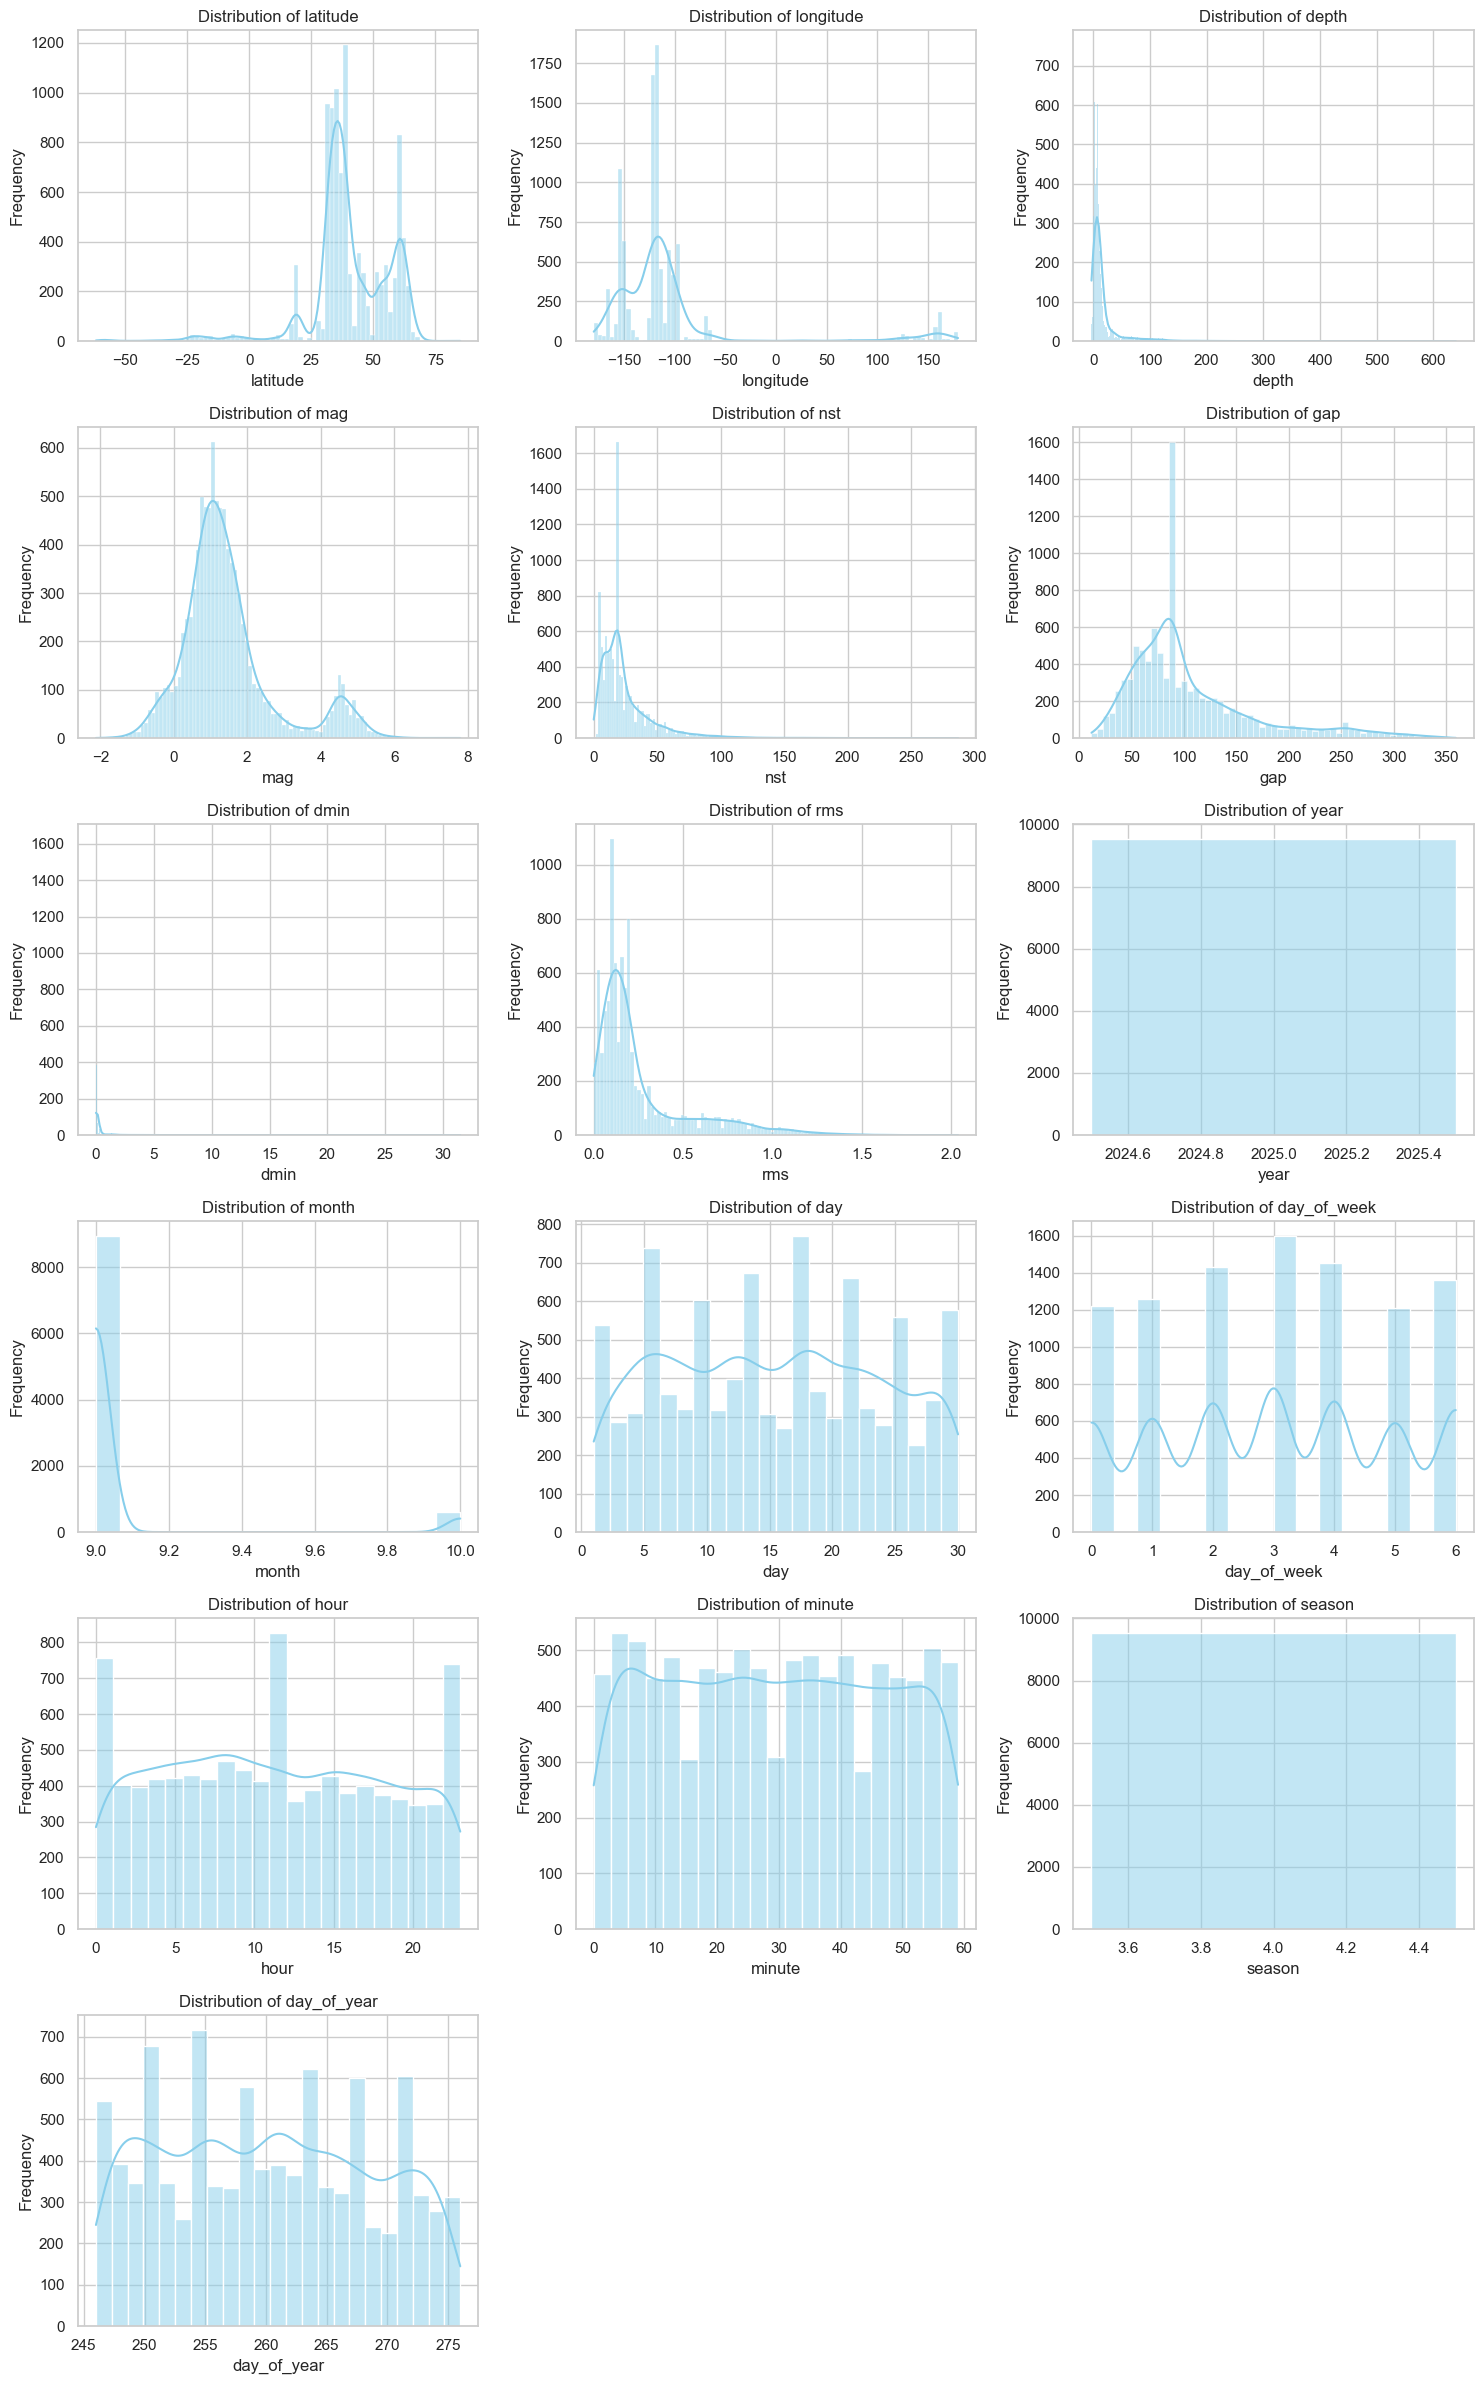

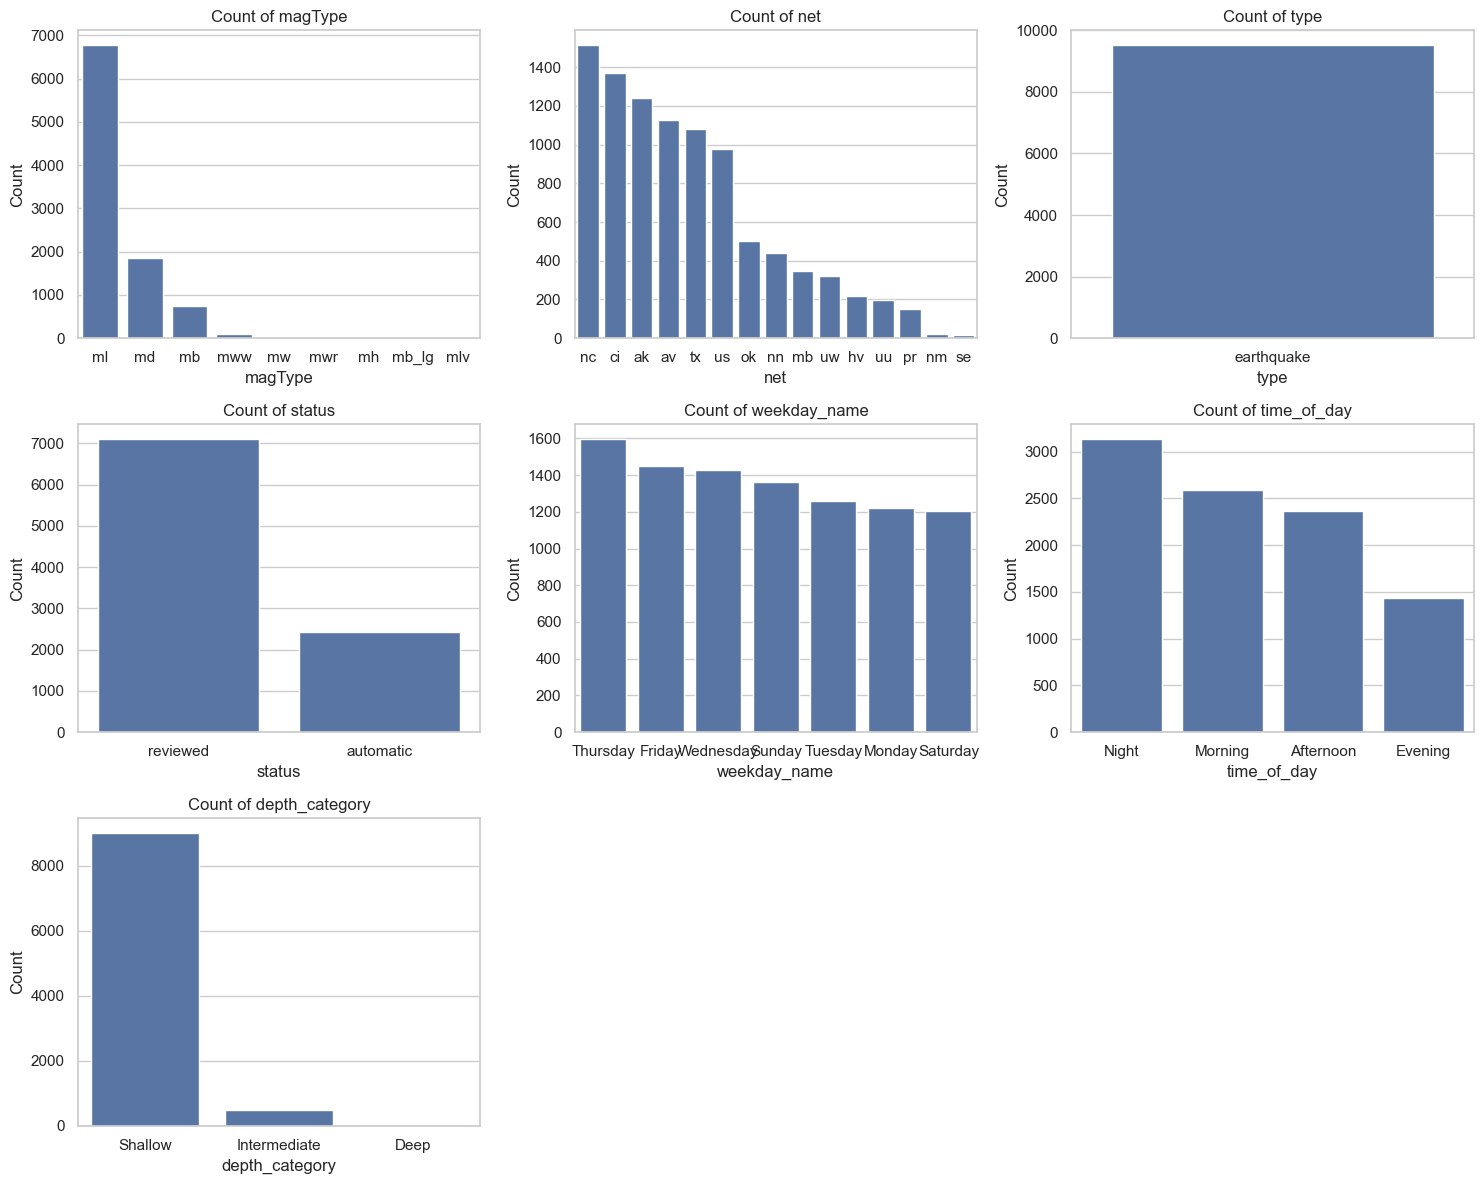

In [145]:
plot_univariate_distributions(eda_eq_df)

In [146]:
# The above analysis states that the data may be skewed (based on the daily observation)
#These extreme values are not anomalies but significant rare events in seismic activity

## Bivariate Analysis

In [147]:
# Divided the analysis in two differnt modules for better visualization..It is a realtime data so the visaulizations may vary

def bivariate_analysis_part1(df):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # 1. Magnitude vs Depth
    sns.scatterplot(data=df, x='depth', y='mag', hue='depth_category',
                    palette='viridis', ax=axes[0], alpha=0.7)
    axes[0].set_title("Magnitude vs Depth")
    axes[0].set_xlabel("Depth (km)")
    axes[0].set_ylabel("Magnitude")

    # 2. Magnitude vs Depth Category
    sns.boxplot(data=df, x='depth_category', y='mag', palette='Set2', ax=axes[1])
    axes[1].set_title("Magnitude Distribution by Depth Category")
    axes[1].set_xlabel("Depth Category")
    axes[1].set_ylabel("Magnitude")

    '''# 3. Magnitude vs Hour of Day
    sns.boxplot(data=df, x='hour', y='mag', ax=axes[2])
    axes[2].set_title("Magnitude Distribution by Hour of Day")
    axes[2].set_xlabel("Hour of Day")
    axes[2].set_ylabel("Magnitude")'''
    
    # 3.Magnitude vs Time of Day
    sns.boxplot(data=df, x='time_of_day', y='mag', order=['Night', 'Morning', 'Afternoon', 'Evening'], ax=axes[2])
    axes[2].set_title("Magnitude Distribution by Time of Day")
    axes[2].set_xlabel("Time of Day")
    axes[2].set_ylabel("Magnitude")

    

    # 4. Magnitude vs Day of Week
    sns.boxplot(data=df, x='day', y='mag', ax=axes[3])
    axes[3].set_title("Magnitude Distribution by Day of Week")
    axes[3].set_xlabel("Day of Week (0=Monday)")
    axes[3].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()


def bivariate_analysis_part2(df):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # 5. RMS vs Magnitude
    sns.scatterplot(data=df, x='rms', y='mag', hue='depth_category',
                    palette='coolwarm', ax=axes[0], alpha=0.7)
    axes[0].set_title("RMS vs Magnitude")
    axes[0].set_xlabel("RMS (s)")
    axes[0].set_ylabel("Magnitude")

    # 6. Location: Latitude vs Longitude (Magnitude as color)
    sns.scatterplot(data=df, x='longitude', y='latitude', hue='mag',
                    palette='coolwarm', ax=axes[1], alpha=0.6)
    axes[1].set_title("Earthquake Location (colored by Magnitude)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    # 7. Depth vs RMS
    sns.scatterplot(data=df, x='depth', y='rms', ax=axes[2], alpha=0.6)
    axes[2].set_title("Depth vs RMS")
    axes[2].set_xlabel("Depth (km)")
    axes[2].set_ylabel("RMS (s)")

    # 8. Correlation Heatmap
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[3])
    axes[3].set_title("Correlation Heatmap – Numeric Features")

    plt.tight_layout()
    plt.show()


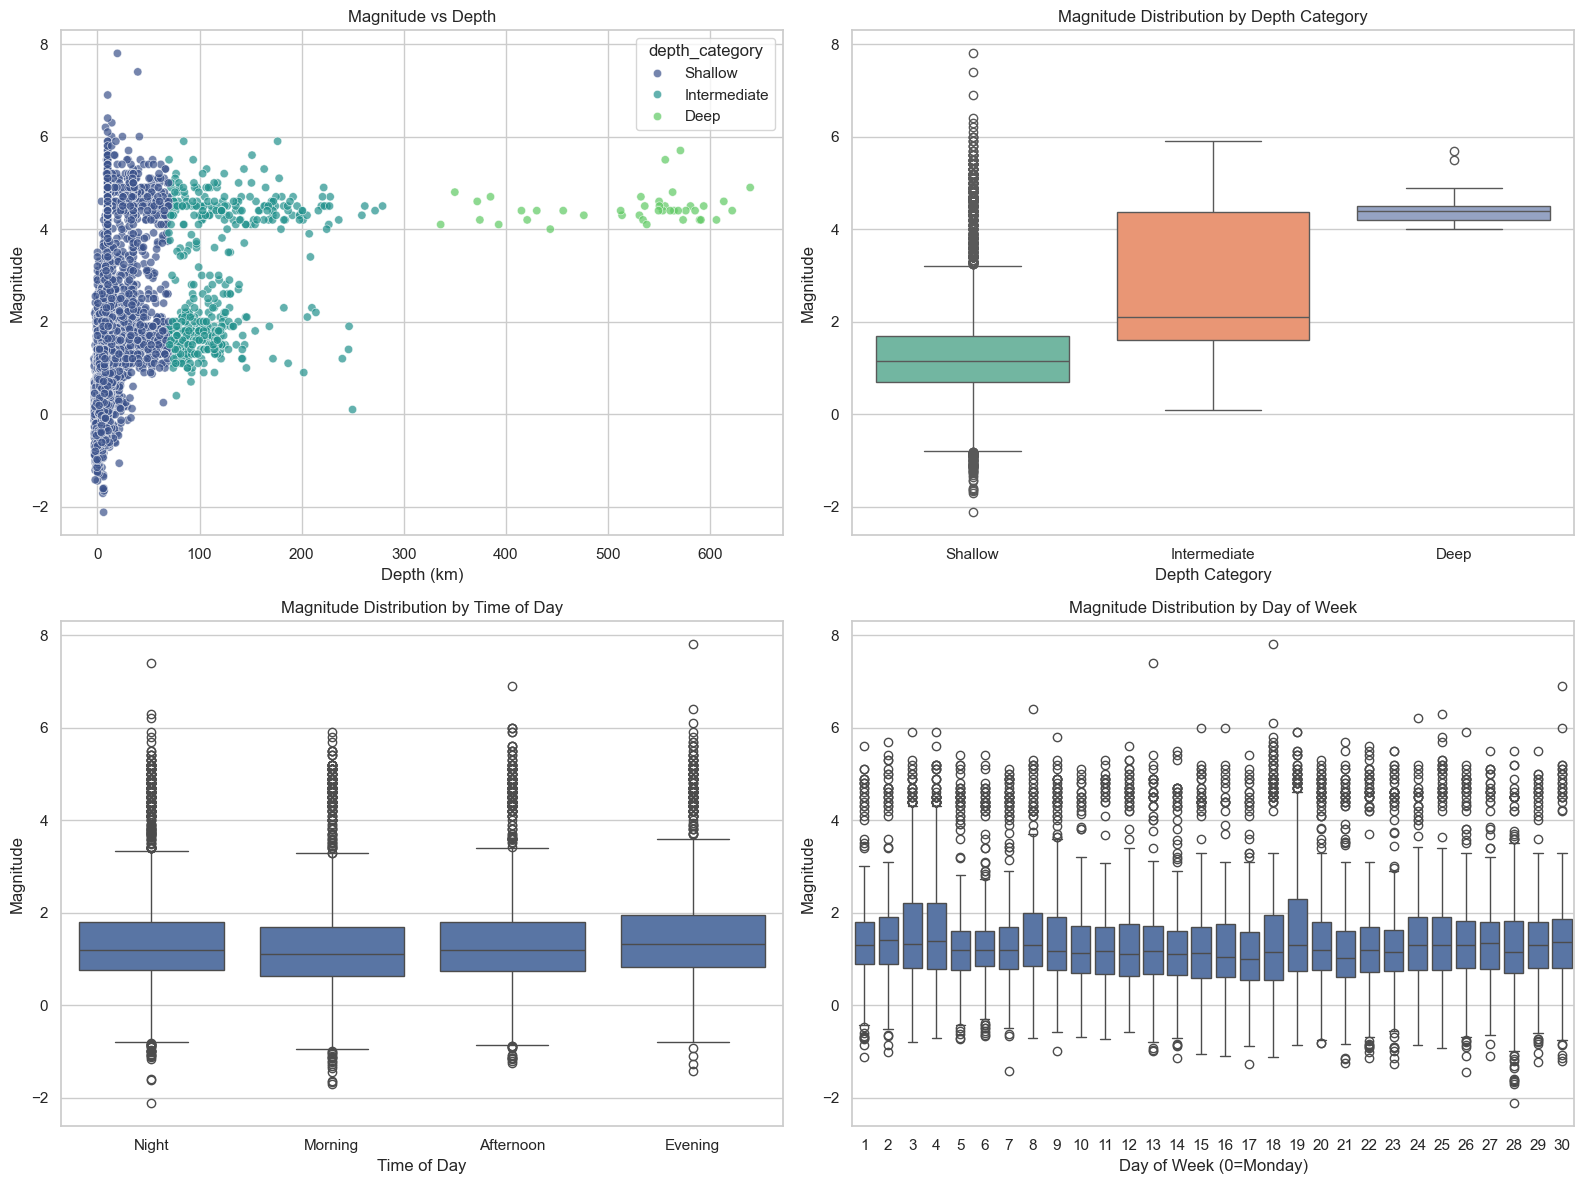

In [148]:
bivariate_analysis_part1(eda_eq_df)

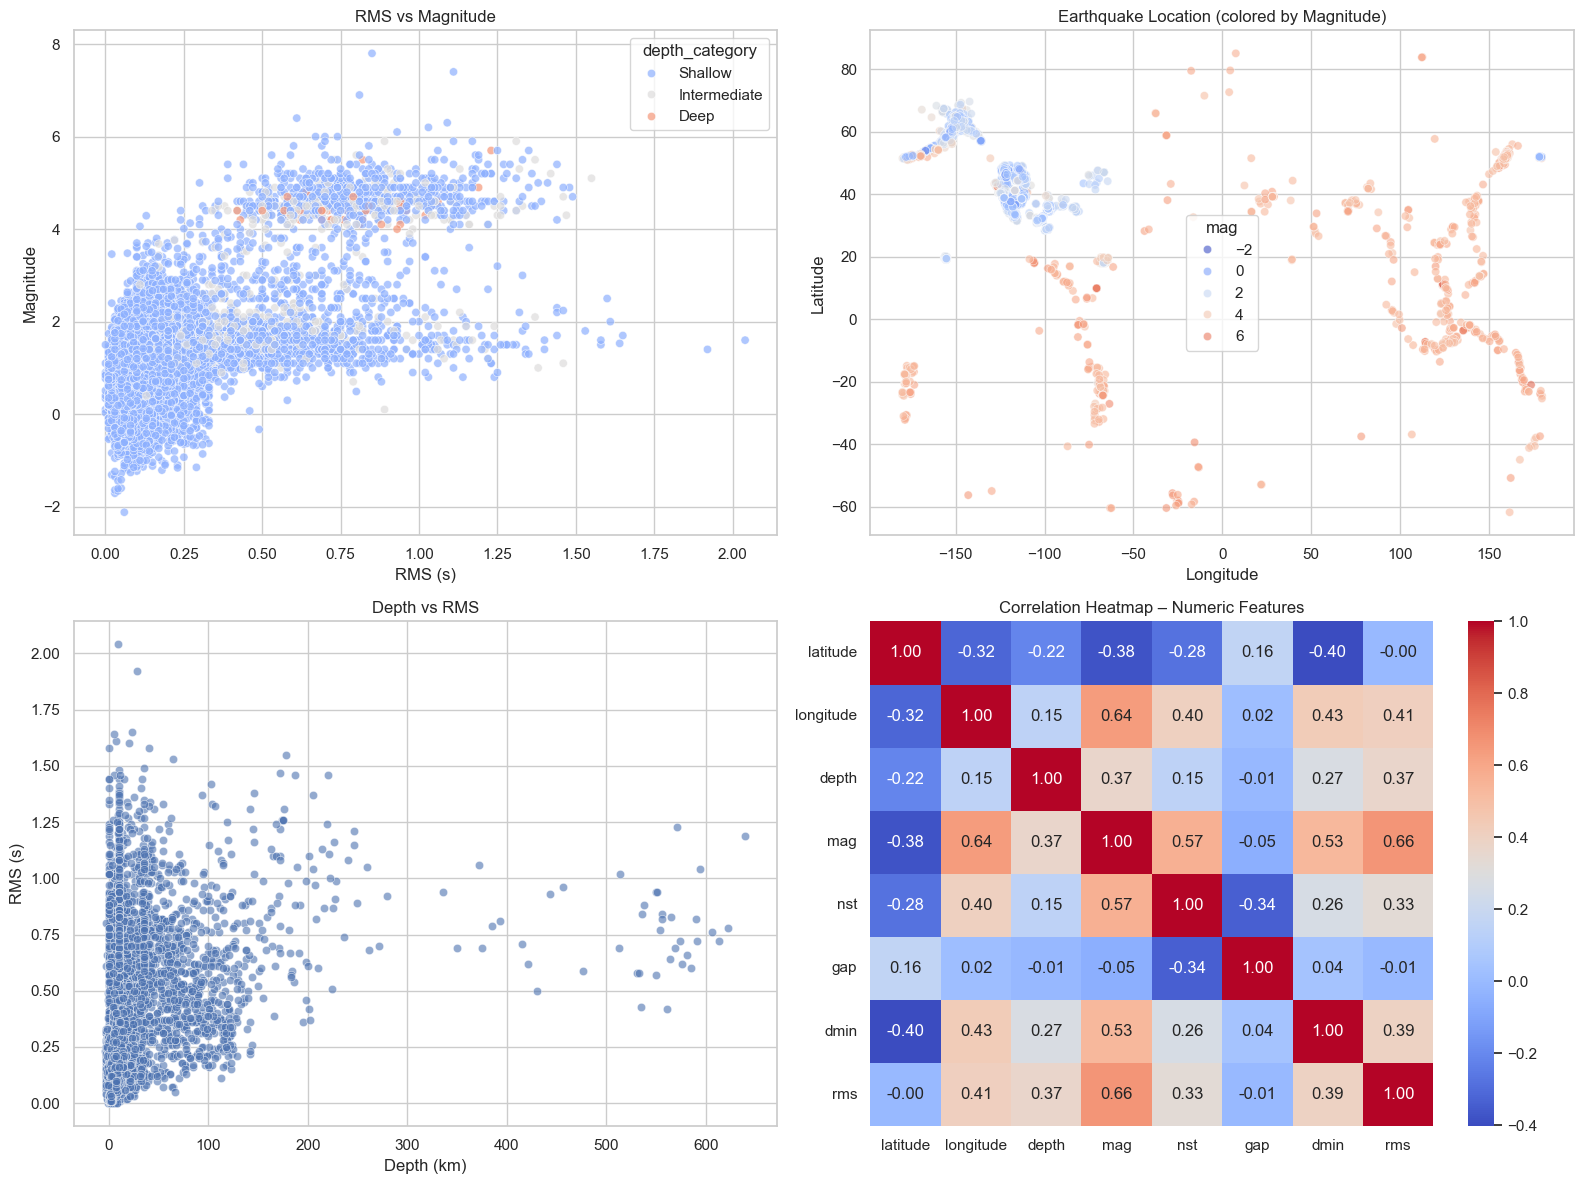

In [149]:
bivariate_analysis_part2(eda_eq_df)

### Outliers

In [150]:
#Handling Ouliers: they are bound to happen in Natural events like Earthquake. 
#Instead of handling them, flags are being generated for the further analysis and prediction

#    Adds outlier flags for each numeric column using Z-score or IQR method,
#   and prints summary of columns containing outliers.

def automated_outlier_flags(df, method='zscore', threshold=3.0):
    df = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    row_outlier_flags = pd.DataFrame(index=df.index)
    
    outlier_summary = {}  # To store outlier counts per column

    for col in numeric_cols:
        if method == 'zscore':
            col_zscore = zscore(df[col].dropna())
            is_outlier = pd.Series(False, index=df.index)
            is_outlier.loc[df[col].dropna().index[np.abs(col_zscore) > threshold]] = True

        elif method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - threshold * IQR
            upper = Q3 + threshold * IQR
            is_outlier = (df[col] < lower) | (df[col] > upper)

        else:
            raise ValueError("method must be 'zscore' or 'iqr'")

        # Add flag to DataFrame
        flag_col = f"{col}_is_outlier"
        df[flag_col] = is_outlier
        row_outlier_flags[flag_col] = is_outlier
        outlier_summary[col] = is_outlier.sum()

    # Combined outlier flag across all columns
    df['is_outlier_any'] = row_outlier_flags.any(axis=1)
    total_outliers = df['is_outlier_any'].sum()

    # Print summary
    print(f"Outlier flags added for {len(numeric_cols)} numeric columns.")
    print(f"Rows with any outlier: {total_outliers} out of {len(df)}")
    print("\nColumns with outliers:")
    for col, count in outlier_summary.items():
        if count > 0:
            print(f" - {col}: {count} outliers")
    return df

In [151]:
earthquake_outlier_flags = automated_outlier_flags(eda_eq_df, method='iqr', threshold=1.5)

Outlier flags added for 16 numeric columns.
Rows with any outlier: 3740 out of 9524

Columns with outliers:
 - latitude: 311 outliers
 - longitude: 687 outliers
 - depth: 1308 outliers
 - mag: 998 outliers
 - nst: 687 outliers
 - gap: 726 outliers
 - dmin: 1410 outliers
 - rms: 1251 outliers
 - month: 592 outliers


In [152]:
# Rows with any outlier
outliers = earthquake_outlier_flags[earthquake_outlier_flags['is_outlier_any']]
display(f"There are {outliers.shape[0]} ouliers in the dataset")

# Outlier flag columns
flag_cols = [col for col in earthquake_outlier_flags.columns if col.endswith('_outlier')]

# Add indicators: any outlier + total count of outliers per row
earthquake_outlier_flags['Any_outlier'] = earthquake_outlier_flags[flag_cols].max(axis=1)
earthquake_outlier_flags['Total_outlier_flags'] = earthquake_outlier_flags[flag_cols].sum(axis=1)

# Check results
display(earthquake_outlier_flags[['Any_outlier', 'Total_outlier_flags']])

'There are 3740 ouliers in the dataset'

Any_outlier  Total_outlier_flags
0            True                    1
1            True                    1
2            True                    1
3            True                    1
4            True                    1
...           ...                  ...
9724        False                    0
9725         True                    1
9726        False                    0
9727        False                    0
9728        False                    0

[9524 rows x 2 columns]

In [153]:
#summary table for outliers

# Calculate percentage of rows flagged as outliers for each feature
summary_table = (earthquake_outlier_flags[flag_cols].mean() * 100).round(2)

# Convert to DataFrame for a nice table view
summary_table = summary_table.reset_index()
summary_table.columns = ["Feature", "% Rows with Outliers"]

print(summary_table)

                   Feature  % Rows with Outliers
0      latitude_is_outlier                  3.27
1     longitude_is_outlier                  7.21
2         depth_is_outlier                 13.73
3           mag_is_outlier                 10.48
4           nst_is_outlier                  7.21
5           gap_is_outlier                  7.62
6          dmin_is_outlier                 14.80
7           rms_is_outlier                 13.14
8          year_is_outlier                  0.00
9         month_is_outlier                  6.22
10          day_is_outlier                  0.00
11  day_of_week_is_outlier                  0.00
12         hour_is_outlier                  0.00
13       minute_is_outlier                  0.00
14       season_is_outlier                  0.00
15  day_of_year_is_outlier                  0.00


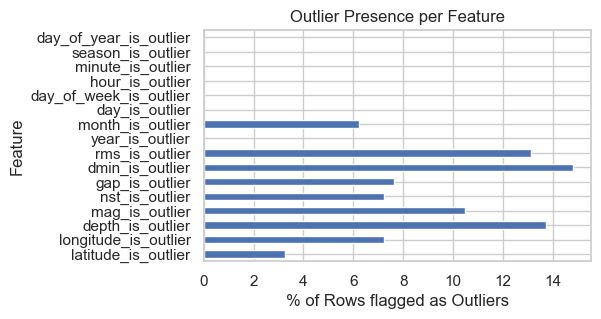

In [154]:
summary_table.plot(
    kind="barh", 
    x="Feature", 
    y="% Rows with Outliers", 
    figsize=(5,3), 
    legend=False
)
plt.xlabel("% of Rows flagged as Outliers")
plt.title("Outlier Presence per Feature")
plt.show()

__Outliers in earthquake datasets are not data errors but real extreme seismic events.  
Removing or correcting them would eliminate 10–15% of valid observations in key features such as depth (13.55%),  
distance (14.74%), rms (13.26%), and magnitude (10.43%). Since Random Forest is robust to outliers, we can safely  
retain them without harming model performance, ensuring that our analysis fully reflects the natural variability of earthquakes.__

### Earthquake visualization for this month

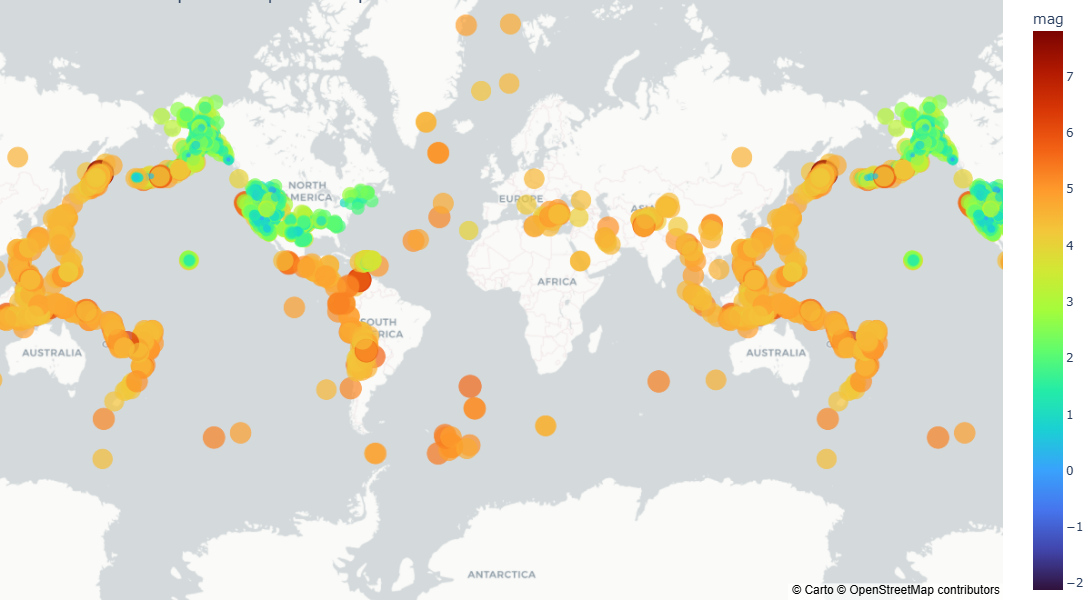

In [155]:
eda_eq_df['size_value'] = np.abs(eda_eq_df['mag']) 
fig = px.scatter_mapbox(
    eda_eq_df,
    lat="latitude",
    lon="longitude",
    color="mag",
    size="size_value",
    hover_name="place",
    hover_data={"mag": True, "depth": True, "time": True},
    color_continuous_scale="Turbo",
    zoom=0.5,  # Zoomed out more
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 0, "lon": 0},  # Center on the world
    margin={"r":0,"t":0,"l":0,"b":0},
    title="Interactive Map of Earthquake Hotspots"
)

fig.show()


### Earthquake visualization for today

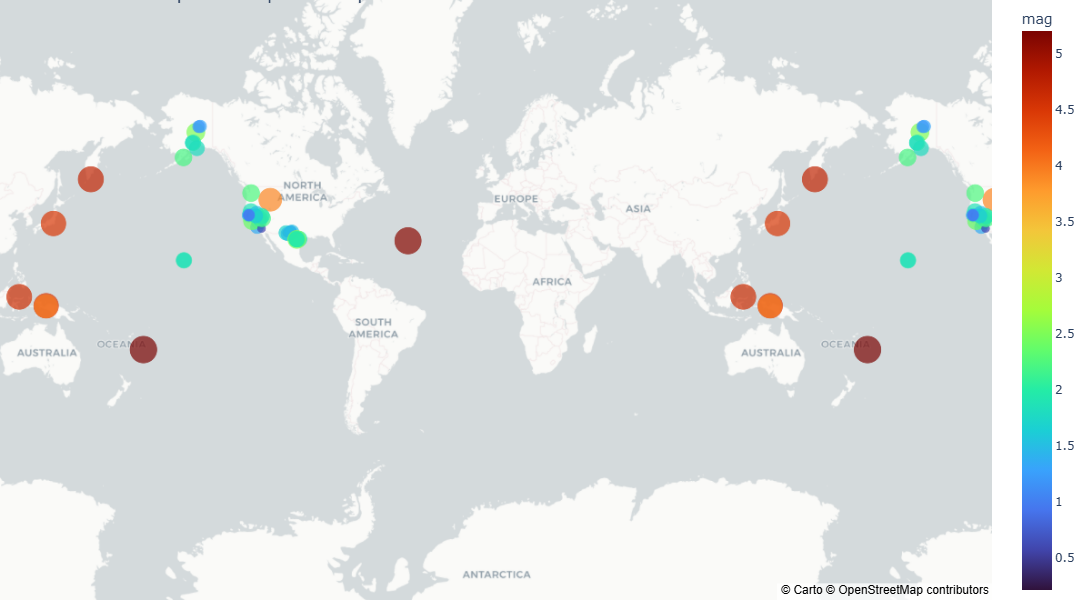

In [156]:
today = pd.to_datetime("today").normalize()
today_df = eda_eq_df[eda_eq_df['time'].dt.date == today.date()]
today_df['size_value'] = np.abs(today_df['mag']) 
fig = px.scatter_mapbox(
    today_df,
    lat="latitude",
    lon="longitude",
    color="mag",
    size="size_value",
    hover_name="place",
    hover_data={"mag": True, "depth": True, "time": True},
    color_continuous_scale="Turbo",
    zoom=0.5,  # Zoomed out more
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 0, "lon": 0},  # Center on the world
    margin={"r":0,"t":0,"l":0,"b":0},
    title="Interactive Map of Earthquake Hotspots"
)
fig.show()


In [157]:
eda_eq_df.drop('size_value',inplace=True,axis=1)

## Feature Engineering

In [158]:
fe_eq_df = eda_eq_df.copy()

### Depth

In [159]:
#Depth Categorization has already been done in univariate analysis
fe_eq_df['depth_category'].value_counts()

depth_category
Shallow         9004
Intermediate     479
Deep              41
Name: count, dtype: int64

### Time of the day

In [160]:
#time of the day has also been extracted in earlier section of code
fe_eq_df['time_of_day'].value_counts()

time_of_day
Night        3136
Morning      2586
Afternoon    2367
Evening      1435
Name: count, dtype: int64

### Fault Lines

In [161]:
# Assuming eq_gdf = earthquakes, faults_gdf = faults
# Both should be in the same projected CRS (important for distance!)
# Example: EPSG:3857 (meters) or EPSG:3395 (World Mercator)
os.environ["SHAPE_RESTORE_SHX"] = "YES"
# Load shapefile
faults_gdf = gpd.read_file("gem_active_faults_harmonized.shp")
# Assign WGS84 if CRS is missing
if faults_gdf.crs is None:
    faults_gdf.set_crs(epsg=4326, inplace=True)
# Convert earthquake DataFrame to GeoDataFrame
eq_gdf = gpd.GeoDataFrame(
    fe_eq_df,  # assuming fe_eq_df has 'latitude' and 'longitude'
    geometry=[Point(xy) for xy in zip(fe_eq_df.longitude, fe_eq_df.latitude)],
    crs="EPSG:4326"
)

################
eq_gdf = eq_gdf.to_crs(epsg=3857)
faults_gdf = faults_gdf.to_crs(epsg=3857)

# Perform nearest spatial join
nearest = gpd.sjoin_nearest(
    eq_gdf, 
    faults_gdf, 
    how="left", 
    distance_col="distance_to_fault_m"
)

# Convert distance from meters to km
nearest["distance_to_fault_km"] = nearest["distance_to_fault_m"] / 1000
nearest = nearest.reset_index(drop=True)
fe_eq_df["distance_to_fault_km"] = nearest["distance_to_fault_km"]
print(fe_eq_df[["latitude", "longitude", "distance_to_fault_km"]].head())

    latitude   longitude  distance_to_fault_km
0  38.834332 -122.815331              7.066777
1  38.472400 -119.488100              1.588171
2  29.031000  -97.870000            682.946412
3  31.603000 -104.124000             68.289227
4  34.065833 -118.824667              4.026909


### Region,  Year_Month,   Monthly_Event_Counts  

In [162]:
# Extract region name (text after the last comma)
fe_eq_df['region'] = fe_eq_df['place'].str.split(',').str[-1].str.strip()

# Create year_month
fe_eq_df['year_month'] = fe_eq_df['time'].dt.to_period('M')

# Calculate monthly counts by region
monthly_counts = (
    fe_eq_df.groupby(['region', 'year_month'])
            .size()
            .reset_index(name='monthly_event_count')
)

# Always drop old monthly_event_count before merging
fe_eq_df = fe_eq_df.drop(columns=['monthly_event_count'], errors='ignore')

# Merge back (clean)
fe_eq_df = fe_eq_df.merge(monthly_counts, on=['region', 'year_month'], how='left')

print(fe_eq_df[['place', 'region', 'year_month', 'monthly_event_count']].head())



                            place      region year_month  monthly_event_count
0              8 km W of Cobb, CA          CA    2025-10                  156
1  4 km SSW of Walker, California  California    2025-10                    8
2  15 km ENE of Falls City, Texas       Texas    2025-10                   81
3        44 km NW of Toyah, Texas       Texas    2025-10                   81
4            7 km N of Malibu, CA          CA    2025-10                  156


### Rolling Mean and Rolling Variance

In [163]:
# Sort so rolling works in chronological order within each region-month
fe_eq_df = fe_eq_df.sort_values(['region', 'year_month', 'time'])
# Rolling window size: N = number of past events to consider
N = 3
# Rolling mean of past magnitudes (within the month, excluding current event)
fe_eq_df['rolling_mag_mean'] = (
    fe_eq_df.groupby(['region', 'year_month'])['mag']
            .transform(lambda x: x.shift().rolling(window=N, min_periods=1).mean()))
# Rolling variance of past magnitudes (within the month, excluding current event)
fe_eq_df['rolling_mag_var'] = (
    fe_eq_df.groupby(['region', 'year_month'])['mag']
            .transform(lambda x: x.shift().rolling(window=N, min_periods=1).var())
)
#Forward Fill (propagate last valid value)
#Keeps row count same, useful if you need continuity.to avoid NaNs
fe_eq_df["rolling_mag_mean"].fillna(method="ffill", inplace=True)
fe_eq_df["rolling_mag_var"].fillna(method="ffill", inplace=True)


In [164]:
fe_eq_df["rolling_mag_mean"].fillna(fe_eq_df['mag'],inplace=True)###FILLING THE EMPTY VALUES WITH ORIGINAL MAGNITUDE 
fe_eq_df["rolling_mag_var"].fillna(0,inplace=True)#SINCE VARIANCE CAN IDEALLY BE ZERO SO FILLING MISSING VALUES WITH ZERO
fe_eq_df[["rolling_mag_var","rolling_mag_mean"]].isnull().sum()


rolling_mag_var     0
rolling_mag_mean    0
dtype: int64

In [165]:
fe_eq_df[['rolling_mag_mean','rolling_mag_var']]

rolling_mag_mean  rolling_mag_var
9218          4.700000         0.000000
9057          4.700000         0.000000
9038          5.150000         0.405000
9005          4.900000         0.390000
8972          4.966667         0.363333
...                ...              ...
2435          4.500000         0.020000
2078          4.500000         0.020000
2061          5.100000         0.020000
7896          5.100000         0.020000
7599          5.100000         0.020000

[9524 rows x 2 columns]

### History Score

In [166]:
#History Score:indicates past seismic activity	Event count × average magnitude, scaled
# Group by region
 
##             Number of Quakes in Past X Period×Mean Magnitude
#  Score=      -------------------------------------------------
#                    Max Observed in Dataset
#A higher history score = region has seen relatively frequent and/or stronger earthquakes compared to the historical maximum in your dataset.
#A lower history score = fewer/weaker earthquakes relative to historical extremes.

history = (
    fe_eq_df.groupby('region')
    .agg(event_count=('mag', 'size'), mean_mag=('mag', 'mean'))
)
history['history_score'] = history['event_count'] * history['mean_mag']
history['history_score'] /= history['history_score'].max()

# Merge back
fe_eq_df = fe_eq_df.merge(history['history_score'], on='region', how='left')

In [167]:
fe_eq_df['history_score']

0       0.028204
1       0.028204
2       0.028204
3       0.028204
4       0.028204
          ...   
9519    0.000287
9520    0.003475
9521    0.003475
9522    0.001552
9523    0.001417
Name: history_score, Length: 9524, dtype: float64

In [168]:
fe_eq_df[['history_score','mag']].corr()

history_score      mag
history_score        1.00000 -0.34331
mag                 -0.34331  1.00000

### Volcano data

In [169]:
# Load volcano data
volcano_df = pd.read_excel("volcanoes_all_list.xlsx")

# Rename for consistency
volcano_df = volcano_df.rename(columns={
    'Latitude': 'volcano_lat',
    'Longitude': 'volcano_lon',
    'Volcano Name': 'volcano_name'
})

# Ensure numeric types
volcano_df['volcano_lat'] = pd.to_numeric(volcano_df['volcano_lat'], errors='coerce')
volcano_df['volcano_lon'] = pd.to_numeric(volcano_df['volcano_lon'], errors='coerce')

# Drop rows without coordinates
volcano_df = volcano_df.dropna(subset=['volcano_lat', 'volcano_lon'])

# Convert degrees to radians for haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Build KDTree using volcano lat/lon
volcano_coords = np.radians(volcano_df[['volcano_lat', 'volcano_lon']].values)  # in radians
tree = KDTree(volcano_coords)

# Query nearest volcano for each earthquake
earthquake_coords = np.radians(fe_eq_df[['latitude', 'longitude']].values)
distances, indices = tree.query(earthquake_coords, k=1)

# Convert angular distance back to km
nearest_dist_km = haversine(
    fe_eq_df['latitude'].values,
    fe_eq_df['longitude'].values,
    volcano_df.iloc[indices]['volcano_lat'].values,
    volcano_df.iloc[indices]['volcano_lon'].values
)

# Add features
fe_eq_df['nearest_volcano_dist_km'] = nearest_dist_km
fe_eq_df['volcano_nearby'] = (fe_eq_df['nearest_volcano_dist_km'] < 50).astype(int)

print(fe_eq_df[['latitude', 'longitude', 'nearest_volcano_dist_km', 'volcano_nearby']].head())


   latitude  longitude  nearest_volcano_dist_km  volcano_nearby
0   34.3840    70.7512              1002.480481               0
1   34.6972    70.7580               995.343647               0
2   34.5739    70.6530              1007.224204               0
3   34.6919    70.6691              1003.452588               0
4   34.5599    70.5260              1018.941168               0


In [170]:
fe_eq_df['volcano_nearby'].value_counts()

volcano_nearby
0    6452
1    3072
Name: count, dtype: int64

In [171]:
near_eq_volcano = fe_eq_df[fe_eq_df["volcano_nearby"] == fe_eq_df["volcano_nearby"].max()]
near_eq_volcano = near_eq_volcano.sort_values(by='nearest_volcano_dist_km')
display(f"Volcanoes near the current earthquake location and magnitude are :{near_eq_volcano["volcano_nearby"].count().item()}")
display(near_eq_volcano[["latitude","longitude","mag","nearest_volcano_dist_km"]])


'Volcanoes near the current earthquake location and magnitude are :3072'

latitude   longitude   mag  nearest_volcano_dist_km
9211  46.199833 -122.180167 -0.10                 0.022539
9329  46.852500 -121.760833  0.29                 0.084302
1602  58.235333 -155.100833  0.00                 0.088740
671   52.075833 -176.128667 -0.28                 0.092988
9225  46.853333 -121.761167  0.23                 0.096148
...         ...         ...   ...                      ...
9122 -19.514000  168.974200  5.00                49.590797
5899  -8.420100  119.462100  4.40                49.600255
6605  39.097000 -119.040500  1.20                49.607216
234   59.801100 -153.599500  1.50                49.630660
6609  39.100600 -119.060100  1.20                49.728983

[3072 rows x 4 columns]

## Monthly Visualization of Earthquake which have volcanoes near by

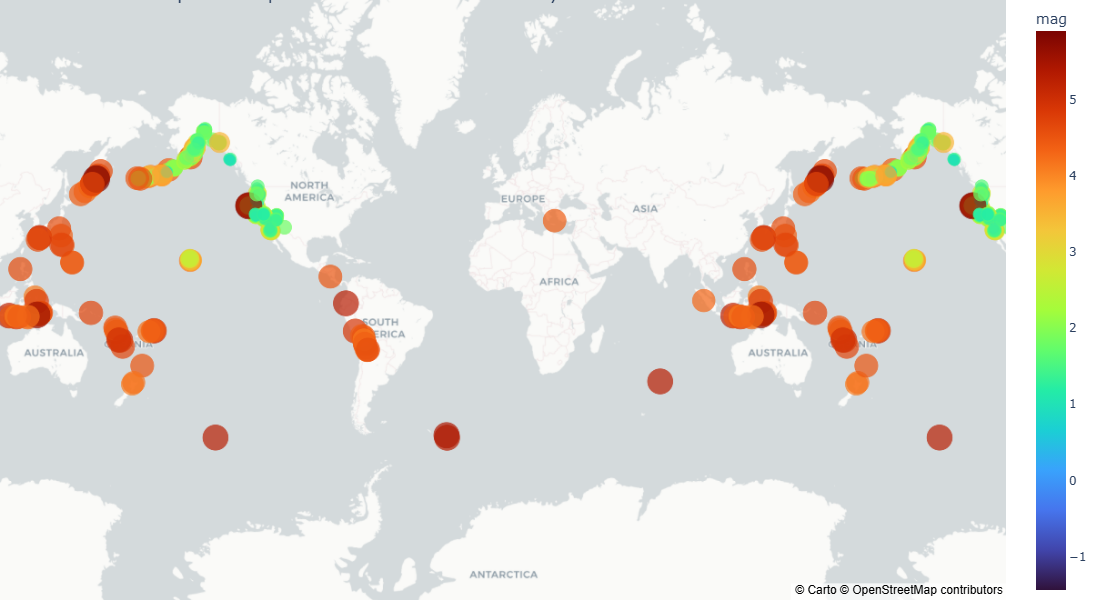

In [172]:
near_eq_volcano['size'] = abs(near_eq_volcano['mag'])
fig = px.scatter_mapbox(
    near_eq_volcano,
    lat="latitude",
    lon="longitude",
    color="mag",
    size="size",
    hover_name="nearest_volcano_dist_km",
    hover_data={"mag": True, "depth": True, "time": True},
    color_continuous_scale="Turbo",
    zoom=0.5,  # Zoomed out more
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 0, "lon": 0},  # Center on the world
    margin={"r":0,"t":0,"l":0,"b":0},
    title="Interactive Map of Earthquake which has volcanoes nearby"
)

fig.show()

# Modeling

#### Applying unsupervised learning--clustering to identify seismic hotspots.

In [173]:
ml_eq_df = fe_eq_df.copy()

In [174]:
#CLUSTERING - DBSCAN Clustering
# Prepare Data
X = ml_eq_df[['latitude', 'longitude']].copy()
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dbscan = DBSCAN(eps=0.3, min_samples=10)
ml_eq_df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

#  DBSCAN Cluster Evaluation
if len(set(ml_eq_df['dbscan_cluster'])) > 1:
    sil_db = silhouette_score(X_scaled, ml_eq_df['dbscan_cluster'])
    dbi_db = davies_bouldin_score(X_scaled, ml_eq_df['dbscan_cluster'])
    ch_db = calinski_harabasz_score(X_scaled, ml_eq_df['dbscan_cluster'])
    print("\nDBSCAN Evaluation:")
    print(f"Silhouette Score: {sil_db:.3f}, Davies-Bouldin Index: {dbi_db:.3f}, Calinski-Harabasz Index: {ch_db:.3f}")
else:
    print("\nDBSCAN did not form multiple clusters.")



DBSCAN Evaluation:
Silhouette Score: 0.641, Davies-Bouldin Index: 1.461, Calinski-Harabasz Index: 7869.568


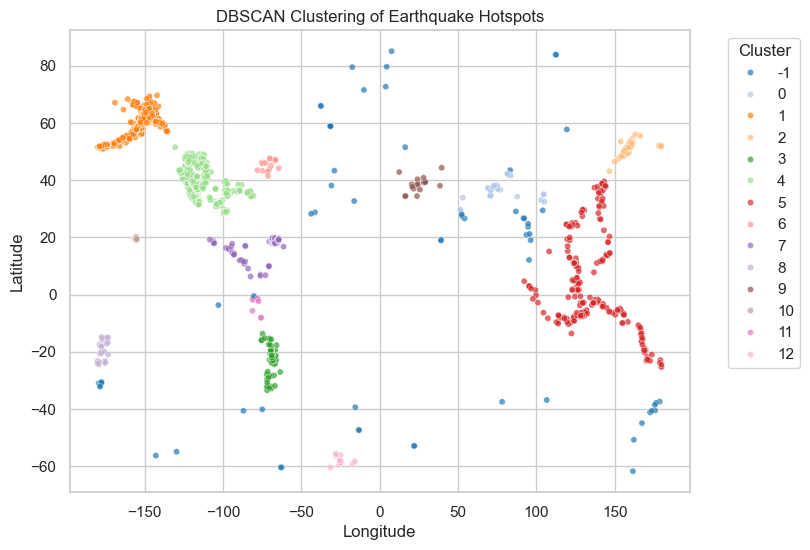

In [175]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ml_eq_df,x='longitude', y='latitude',hue='dbscan_cluster',palette='tab20',s=20, alpha=0.7)
plt.title("DBSCAN Clustering of Earthquake Hotspots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

_Regions with dense DBSCAN clusters could be considered high-risk earthquake hotspots.  
Noise points (-1) might be less critical for risk assessment but could indicate rare events in normally inactive areas._

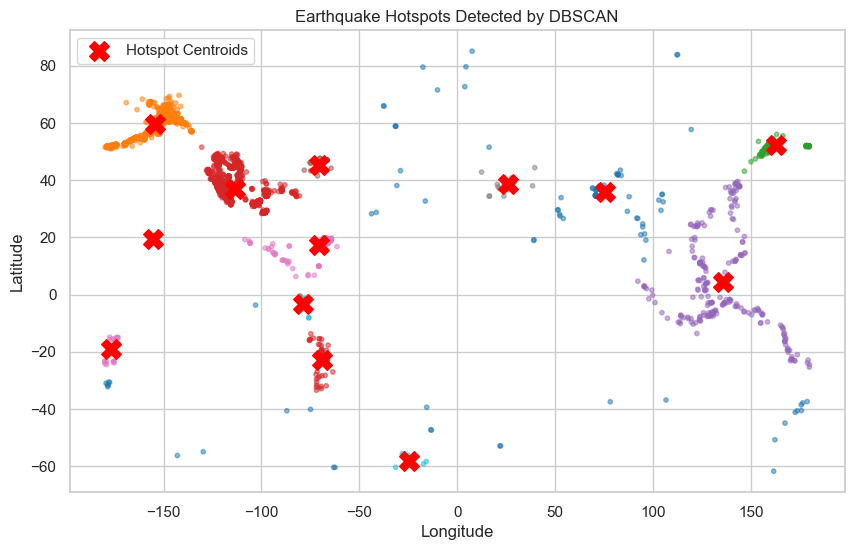

In [176]:
centroids = (
    ml_eq_df[ml_eq_df['dbscan_cluster'] != -1]
    .groupby('dbscan_cluster')[['longitude', 'latitude']]
    .mean()
    .reset_index()
)
plt.figure(figsize=(10,6))
plt.scatter(ml_eq_df['longitude'], fe_eq_df['latitude'], 
            c=ml_eq_df['dbscan_cluster'], cmap='tab10', s=10, alpha=0.5)

plt.scatter(centroids['longitude'], centroids['latitude'], 
            c='red', marker='X', s=200, label='Hotspot Centroids')

plt.title("Earthquake Hotspots Detected by DBSCAN")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

## Time-series methods to forecast daily or weekly seismic activity

In [177]:
# Ensure datetime column
ml_eq_df['date'] = pd.to_datetime(ml_eq_df[['year', 'month', 'day']])
# DAILY AGGREGATION 
daily_df = (
    ml_eq_df.groupby('date')
    .agg(
        daily_avg_mag=('mag', 'mean'),
        daily_event_count=('id', 'count')
    )
    .reset_index()
    .set_index('date')
    .asfreq('D')   # fill in missing days with NaN
)

# WEEKLY AGGREGATION
weekly_df = (
    daily_df.resample('W')
    .agg(
        weekly_avg_mag=('daily_avg_mag', 'mean'),
        weekly_event_count=('daily_event_count', 'sum')
    )
    .reset_index()
    .set_index('date')
)

#  MONTHLY AGGREGATION
monthly_df = (
    ml_eq_df.groupby(['year','month'])
    .agg(
        monthly_avg_mag=('mag', 'mean'),
        monthly_event_count=('id', 'count')
    )
    .reset_index()
)

# Convert (year, month) → proper datetime (YYYY-MM-01)
monthly_df['date'] = pd.to_datetime(
    monthly_df['year'].astype(str) + '-' + monthly_df['month'].astype(str) + '-01'
)
monthly_df = monthly_df.set_index('date').asfreq('MS')  # MS = Month Start

# ---------------- FLEXIBLE SELECTOR ----------------
if mode == "monthly":
    timeseries_df = {
        "daily": daily_df,      # last 30 days daily
        "weekly": weekly_df     # last 30 days weekly
    }
elif mode == "yearly":
    timeseries_df = {
        "daily": daily_df,      # full year daily
        "weekly": weekly_df,    # full year weekly
        "monthly": monthly_df   # full year monthly
    }
else:
    raise ValueError("mode must be 'monthly' or 'yearly'")

# ---------------- DISPLAY ----------------
print("\n==== Final Time-Series DF ====")
if mode == "monthly":
    print("Daily DF:\n", timeseries_df["daily"].head())
    print("\nWeekly DF:\n", timeseries_df["weekly"].head())
elif mode == "yearly":
    print("Daily DF:\n", timeseries_df["daily"].head())
    print("\nWeekly DF:\n", timeseries_df["weekly"].head())
    print("\nMonthly DF:\n", timeseries_df["monthly"].head())



==== Final Time-Series DF ====
Daily DF:
             daily_avg_mag  daily_event_count
date                                        
2025-09-03       1.745128                234
2025-09-04       1.739677                310
2025-09-05       1.397328                393
2025-09-06       1.421681                345
2025-09-07       1.499499                359

Weekly DF:
             weekly_avg_mag  weekly_event_count
date                                          
2025-09-07        1.560663                1641
2025-09-14        1.418130                2312
2025-09-21        1.430148                2335
2025-09-28        1.450174                2067
2025-10-05        1.577119                1169


In [178]:
#1. Prepare Data
# Work with daily event counts
daily_series = timeseries_df["daily"]["daily_event_count"].copy()
# Fill missing days (if any) with 0, since no quakes = 0 count
daily_series = daily_series.fillna(0)
# Weekly aggregate
weekly_series = daily_series.resample("W").sum()


In [179]:
daily_series  #Future Event counts using Daily series

date
2025-09-03    234
2025-09-04    310
2025-09-05    393
2025-09-06    345
2025-09-07    359
2025-09-08    319
2025-09-09    346
2025-09-10    258
2025-09-11    317
2025-09-12    399
2025-09-13    339
2025-09-14    334
2025-09-15    307
2025-09-16    271
2025-09-17    380
2025-09-18    389
2025-09-19    366
2025-09-20    297
2025-09-21    325
2025-09-22    336
2025-09-23    323
2025-09-24    278
2025-09-25    321
2025-09-26    239
2025-09-27    226
2025-09-28    344
2025-09-29    260
2025-09-30    317
2025-10-01    279
2025-10-02    260
2025-10-03     53
Freq: D, Name: daily_event_count, dtype: int64

In [180]:
weekly_series

date
2025-09-07    1641
2025-09-14    2312
2025-09-21    2335
2025-09-28    2067
2025-10-05    1169
Freq: W-SUN, Name: daily_event_count, dtype: int64

In [181]:
#2. Baseline Forecast Models
#We start simple before trying advanced ML:
#(a) Naïve Forecast (Persistence)
#Tomorrow = today’s count.
naive_forecast = daily_series.shift(1)  # lag-1 forecast
#(b) Moving Average Forecast
moving_avg_forecast = daily_series.rolling(window=7).mean().shift(1)

In [182]:
moving_avg_forecast

date
2025-09-03           NaN
2025-09-04           NaN
2025-09-05           NaN
2025-09-06           NaN
2025-09-07           NaN
2025-09-08           NaN
2025-09-09           NaN
2025-09-10    329.428571
2025-09-11    332.857143
2025-09-12    333.857143
2025-09-13    334.714286
2025-09-14    333.857143
2025-09-15    330.285714
2025-09-16    328.571429
2025-09-17    317.857143
2025-09-18    335.285714
2025-09-19    345.571429
2025-09-20    340.857143
2025-09-21    334.857143
2025-09-22    333.571429
2025-09-23    337.714286
2025-09-24    345.142857
2025-09-25    330.571429
2025-09-26    320.857143
2025-09-27    302.714286
2025-09-28    292.571429
2025-09-29    295.285714
2025-09-30    284.428571
2025-10-01    283.571429
2025-10-02    283.714286
2025-10-03    275.000000
Freq: D, Name: daily_event_count, dtype: float64

In [183]:
#3. Statistical Forecasting

# Fit ARIMA on daily event count
model = ARIMA(daily_series, order=(5,1,0))  # p,d,q tune later
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)  # forecast 7 days ahead
print(forecast)

2025-10-04    239.174920
2025-10-05    246.376988
2025-10-06    283.491749
2025-10-07    238.739115
2025-10-08    255.037872
2025-10-09    157.673936
2025-10-10    220.002032
Freq: D, Name: predicted_mean, dtype: float64


In [184]:
# Forecast Comparison
# ----------------------------

# Moving Average (MA):
# - Smooths daily earthquake counts, showing overall trend
# - Example: 2025-08-27 → 302.86, 2025-09-06 → 360.14

# ARIMA:
# - Forecasts future daily counts, capturing short-term fluctuations
# - Example: 2025-09-20 → 277.82, 2025-09-25 → 229.77

# Observation:
# - MA shows smoothed trend; ARIMA provides short-term forecasts


## Build regression or classification models to predict event magnitudes or likelihood of significant aftershocks.

In [185]:
#Dropping Useless columns
ml_eq_df.drop(columns=['id','place','year_month','date','year','month','day','hour','minute','day_of_week','weekday_name','day_of_year'],axis=1,inplace=True)

In [186]:
numeric_features = [
    'latitude', 'longitude', 'depth',
    'monthly_event_count', 'rolling_mag_mean', 'rolling_mag_var',
    'history_score', 'distance_to_fault_km', 'nearest_volcano_dist_km','dmin', 'rms', 'nst','gap']
# keep only those that actually exist to avoid KeyError
numeric_features = [c for c in numeric_features if c in ml_eq_df.columns]

categorical_features = [
    'magType', 'region', 'season', 'time_of_day',
    'weekday_name', 'is_weekend', 'depth_category',
    'volcano_nearby', 'kmeans_cluster', 'dbscan_cluster', 'type', 'status'
]
categorical_features = [c for c in categorical_features if c in ml_eq_df.columns]

In [187]:
#  Function to find the distance between the two locations having their respective latitudes and longitudes
def haversine_km_vec(lat1, lon1, lat2_arr, lon2_arr):
    """Vectorized haversine distance (in km) from a single point (lat1, lon1) 
    to multiple points (lat2_arr, lon2_arr).
    Returns:Distances in kilometers"""
    R = 6371.0  # Earth radius in km
 # Convert all to radians
    lat1r = radians(lat1)
    lon1r = radians(lon1)
    lat2r = np.radians(lat2_arr)
    lon2r = np.radians(lon2_arr)
    dlat = lat2r - lat1r
    dlon = lon2r - lon1r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1r) * np.cos(lat2r) * np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [188]:
 new_df = ml_eq_df.sort_values('time').reset_index(drop=True).copy()
new_df.head(10)

time   latitude   longitude     depth   mag magType  \
0 2025-09-03 05:54:30.510  38.835667 -122.794334    2.0600  1.40      md   
1 2025-09-03 06:04:39.610  37.623500 -119.024667    1.5700  0.19      md   
2 2025-09-03 06:04:58.210  37.626500 -119.037333   -0.7100  0.24      md   
3 2025-09-03 06:12:12.281  60.776900 -151.965800  202.1000  0.90      ml   
4 2025-09-03 06:14:40.190  19.401333 -155.270667   10.3000  1.63      ml   
5 2025-09-03 06:19:23.657  31.558000 -104.168000    7.3816  1.20      ml   
6 2025-09-03 06:21:59.770  33.528000 -116.727167    6.0500  0.71      ml   
7 2025-09-03 06:24:52.030  52.314667 -174.177333    6.8700  0.45      ml   
8 2025-09-03 06:26:49.196  63.429500 -150.891000    0.0000  1.70      ml   
9 2025-09-03 06:26:52.030  38.758333 -122.718667    2.1600  0.35      md   

    nst    gap      dmin   rms  ... depth_category distance_to_fault_km  \
0  28.0   55.0  0.004149  0.03  ...        Shallow                  NaN   
1  11.0   74.0  0.011030  0.04  ...        Shallow                  NaN   
2  11.0   69.0  0.018110  0.08  ...        Shallow                  NaN   
3  19.0   88.0  0.053310  0.37  ...   Intermediate                  NaN   
4  23.0   51.0  0.005347  0.16  ...        Shallow                  NaN   
5  21.0   70.0  0.000000  0.10  ...        Shallow                  NaN   
6  44.0   32.0  0.038250  0.16  ...        Shallow                  NaN   
7   7.0  167.0  0.016980  0.27  ...        Shallow                  NaN   
8  19.0   88.0  0.053310  1.44  ...        Shallow                  NaN   
9   6.0  159.0  0.005835  0.01  ...        Shallow                  NaN   

   region monthly_event_count  rolling_mag_mean  rolling_mag_var  \
0      CA                2674          4.633333         0.063333   
1      CA                2674          1.400000         0.063333   
2      CA                2674          0.795000         0.732050   
3  Alaska                2257          4.566667         0.093333   
4  Hawaii                 203          4.466667         0.123333   
5   Texas                 798          1.953333         0.100033   
6      CA                2674          0.610000         0.468700   
7  Alaska                2257          0.900000         0.093333   
8  Alaska                2257          0.675000         0.101250   
9      CA                2674          0.380000         0.082300   

  history_score nearest_volcano_dist_km  volcano_nearby dbscan_cluster  
0      1.000000               15.084881               1              4  
1      1.000000                1.054787               1              4  
2      1.000000                0.686276               1              4  
3      0.861499               60.051360               0              1  
4      0.132246                2.777847               1             10  
5      0.399717              297.052170               0              4  
6      1.000000              109.561369               0              4  
7      0.861499                3.175842               1              1  
8      0.861499              213.692845               0              1  
9      1.000000               23.952216               1              4  

[10 rows x 27 columns]

_Label an earthquake as “aftershock” if it occurs within 7 days and within 50 km of a mainshock.  
This becomes your classification label (aftershock = 1 / 0)._

__1)Aftershock labelling__

In [189]:
def label_aftershocks(df, days=7, radius_km=100, min_mag=4.0, time_col="time",
                      lat_col="latitude", lon_col="longitude", mag_col="mag"):
    """
    Add column 'label_aftershock' = 1 if a subsequent event occurs within `days` AND within `radius_km`
    AND has magnitude >= min_mag. Returns a new DataFrame (copy).
    This uses a time-window slice to avoid full O(N^2) comparisons.
    """
    df = df.sort_values(time_col).reset_index(drop=True).copy()
    df[time_col] = pd.to_datetime(df[time_col])
    n = len(df)
    labels = np.zeros(n, dtype=int)

    # For faster slicing, get time series index
    times = df[time_col].values

    for i in range(n):
        t0 = times[i]
        # slice: events strictly after t0 and within days
        t_upper = t0 + np.timedelta64(int(days), 'D')
        # boolean mask on numpy times array (fast)
        mask_time = (times > t0) & (times <= t_upper)
        if not mask_time.any():
            continue
        cand_idx = np.nonzero(mask_time)[0]
        # narrow down by magnitude filter first (cheap)
        cand_mags = df.iloc[cand_idx][mag_col].values
        mag_mask = cand_mags >= min_mag
        if not mag_mask.any():
            continue
        cand_idx = cand_idx[mag_mask]
        # compute distances vectorized
        lat0 = df.at[i, lat_col]; lon0 = df.at[i, lon_col]
        cand_lats = df.iloc[cand_idx][lat_col].values
        cand_lons = df.iloc[cand_idx][lon_col].values
        dists = haversine_km_vec(lat0, lon0, cand_lats, cand_lons)
        if (dists <= radius_km).any():
            labels[i] = 1

    df["label_aftershock"] = labels
    return df

__2)Feature selection / preprocessing__

In [190]:
# Use your rich set of existing features. Adjust for smaller/larger list.
numeric_features = [
    'latitude', 'longitude', 'depth',
    'monthly_event_count', 'rolling_mag_mean', 'rolling_mag_var',
    'history_score', 'distance_to_fault_km', 'nearest_volcano_dist_km','dmin', 'rms', 'nst','gap']
# keep only those that actually exist to avoid KeyError
numeric_features = [c for c in numeric_features if c in ml_eq_df.columns]

categorical_features = [
    'magType', 'region', 'season', 'time_of_day',
    'weekday_name', 'is_weekend', 'depth_category',
    'volcano_nearby', 'kmeans_cluster', 'dbscan_cluster', 'type', 'status'
]
categorical_features = [c for c in categorical_features if c in ml_eq_df.columns]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ], remainder='drop'
)

__3) Regression: predict magnitude__

In [191]:
def run_regression(df, time_col="time", target_col="mag"):
    df = df.dropna(subset=[time_col, target_col]).copy()
    #df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)

    X = df[numeric_features + categorical_features].copy()
    y = df[target_col].copy()

    # time-based split (chronological)
    split_idx = int(0.8 * len(df))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = Pipeline([
        ("preproc", preprocessor),
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "model": model,
        "X_test_index": X_test.index,
        "y_test": y_test,
        "y_pred": y_pred
    }
    return metrics


__4)Classification: predict aftershock__

In [192]:
def run_classification(df, time_col="time", label_col="label_aftershock", preprocessor=None):
    # Check target column exists
    if label_col not in df.columns:
        raise ValueError(f"{label_col} not found. Run label_aftershocks() first.")

    # Drop rows with missing target or time
    df = df.dropna(subset=[time_col, label_col])
    
    # Split features and target
    X = df.drop(columns=[time_col, label_col])
    y = df[label_col]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Default preprocessor with imputation
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[
                # Numeric: median imputation
                ("num", SimpleImputer(strategy="median"), numeric_features),
                # Categorical: mode imputation + one-hot encoding
                ("cat", Pipeline([
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(handle_unknown="ignore"))
                ]), categorical_features)
            ]
        )

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Random Forest pipeline
    rf = Pipeline([
        ("preproc", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Train model
    start_train = time.time()
    rf.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Predictions & metrics
    start_pred = time.time()
    probas = rf.predict_proba(X_test)[:, 1]
    end_pred = time.time()
    inference_time = end_pred - start_pred

    # Compute evaluation metrics
    roc_auc = roc_auc_score(y_test, probas)
    pr_auc = average_precision_score(y_test, probas)
    f1_05 = f1_score(y_test, (probas >= 0.5).astype(int))

    precision, recall, thresholds = precision_recall_curve(y_test, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_f1 = f1_scores[best_idx]

    metrics = {
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc,
        "F1_at_0.5": f1_05,
        "best_threshold": best_threshold,
        "F1_at_best": best_f1,
        "Train_Time_sec": train_time,
        "Inference_Time_sec": inference_time
    }

    return rf, metrics


__5) Run labeling + models (run)__

In [193]:
# Adjust parameters as needed:
AFTER_DAYS = 7
AFTER_RADIUS_KM = 100
AFTER_MIN_MAG = 4.0
print("Adding aftershock labels (this may take a few moments depending on dataset size)...")
ml_eq_df_labeled = label_aftershocks(
    ml_eq_df,
    days=AFTER_DAYS,
    radius_km=AFTER_RADIUS_KM,
    min_mag=AFTER_MIN_MAG,
    time_col="time",
    lat_col="latitude",
    lon_col="longitude",
    mag_col="mag"
)
print("Done. Positive aftershock labels:", ml_eq_df_labeled['label_aftershock'].sum(), "/", len(ml_eq_df_labeled))

#Run Regression model
print("Running regression for magnitude...")
reg_res = run_regression(ml_eq_df_labeled)
print("Regression metrics: MAE={:.4f}, RMSE={:.4f}, R2={:.4f}".format(reg_res["MAE"], reg_res["RMSE"], reg_res["R2"]))

#Run classifiction model
print("Running aftershock classification...")
rf_model, cls_res = run_classification(ml_eq_df_labeled)

#Results
print("Classification results (summary):")
print(f"ROC_AUC     = {cls_res['ROC_AUC']:.4f}")
print(f"PR_AUC      = {cls_res['PR_AUC']:.4f}")
print(f"F1@0.5      = {cls_res['F1_at_0.5']:.4f}")
print(f"Best thresh = {cls_res['best_threshold']:.3f}")
print(f"F1@best     = {cls_res['F1_at_best']:.4f}")
print(f"Train time  = {cls_res['Train_Time_sec']:.3f} sec")
print(f"Inference   = {cls_res['Inference_Time_sec']:.3f} sec")

# Expose results for later use
regression_results = reg_res
classification_results = cls_res
labeled_df = ml_eq_df_labeled


Adding aftershock labels (this may take a few moments depending on dataset size)...
Done. Positive aftershock labels: 719 / 9524
Running regression for magnitude...
Regression metrics: MAE=0.3056, RMSE=0.1942, R2=0.8749
Running aftershock classification...
Classification results (summary):
ROC_AUC     = 0.9684
PR_AUC      = 0.7707
F1@0.5      = 0.6441
Best thresh = 0.203
F1@best     = 0.6685
Train time  = 12.256 sec
Inference   = 0.408 sec


In [200]:
# Prepare timestamped filename
#timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"earthquake_models_and_data.pkl.gz"        #_{timestamp}.pkl"

# Bundle everything to save
data_to_save = {
    "labeled_df": labeled_df,
    "regression_results": regression_results,
    "regression_model": reg_res["model"],  # trained RandomForestRegressor
    "classification_results": classification_results,
    "classification_model": rf_model       # trained RandomForestClassifier
}

# Save as pickle
with gzip.open(filename, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"✅ All data and models saved to {filename}")


✅ All data and models saved to earthquake_models_and_data.pkl.gz


# Temporal validation strategy using methods like sliding-window cross-validation.

In [195]:
# Sort by time first
ml_eq_df = ml_eq_df.sort_values("time")
# 80% earliest data = train, last 20% = test
split_point = int(len(ml_eq_df) * 0.8)
train, test = ml_eq_df.iloc[:split_point], ml_eq_df.iloc[split_point:]

Pros: Simple, avoids leakage.

Cons: Only one split → may not generalize well.

In [196]:
def sliding_window_cv(X, y, model, train_size, test_size, step_size):
    n_samples = len(X)
    results = []

    for start in range(0, n_samples - train_size - test_size + 1, step_size):
        train_start = start
        train_end   = start + train_size
        test_end    = train_end + test_size

        X_train, y_train = X.iloc[train_start:train_end], y.iloc[train_start:train_end]
        X_test, y_test   = X.iloc[train_end:test_end], y.iloc[train_end:test_end]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        r2   = r2_score(y_test, y_pred)

        results.append((train_end, test_end, rmse, mae, r2))

    return results


# Define features and target
X = ml_eq_df.drop(columns=["mag", "time"])
X = X[numeric_features]
y = ml_eq_df["mag"]

# Model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Run sliding-window CV
results = sliding_window_cv(
    X, y,
    model=rfr,
    train_size=2000,
    test_size=500,
    step_size=500   # non-overlapping folds
)

# Print summary
for i, (train_end, test_end, rmse, mae, r2) in enumerate(results, 1):
    print(f"Fold {i}: TrainEnd={train_end}, TestEnd={test_end}, "
          f"RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")


Fold 1: TrainEnd=2000, TestEnd=2500, RMSE=0.470, MAE=0.327, R2=0.843
Fold 2: TrainEnd=2500, TestEnd=3000, RMSE=0.450, MAE=0.326, R2=0.852
Fold 3: TrainEnd=3000, TestEnd=3500, RMSE=0.466, MAE=0.328, R2=0.869
Fold 4: TrainEnd=3500, TestEnd=4000, RMSE=0.446, MAE=0.329, R2=0.851
Fold 5: TrainEnd=4000, TestEnd=4500, RMSE=0.412, MAE=0.305, R2=0.880
Fold 6: TrainEnd=4500, TestEnd=5000, RMSE=0.436, MAE=0.306, R2=0.843
Fold 7: TrainEnd=5000, TestEnd=5500, RMSE=0.399, MAE=0.289, R2=0.943
Fold 8: TrainEnd=5500, TestEnd=6000, RMSE=0.413, MAE=0.297, R2=0.923
Fold 9: TrainEnd=6000, TestEnd=6500, RMSE=0.368, MAE=0.276, R2=0.918
Fold 10: TrainEnd=6500, TestEnd=7000, RMSE=0.362, MAE=0.258, R2=0.921
Fold 11: TrainEnd=7000, TestEnd=7500, RMSE=0.437, MAE=0.308, R2=0.886
Fold 12: TrainEnd=7500, TestEnd=8000, RMSE=0.450, MAE=0.313, R2=0.885
Fold 13: TrainEnd=8000, TestEnd=8500, RMSE=0.562, MAE=0.384, R2=0.788
Fold 14: TrainEnd=8500, TestEnd=9000, RMSE=0.466, MAE=0.334, R2=0.846
Fold 15: TrainEnd=9000, TestE

Summary of Sliding-Window CV Performance:


mean       std       min       max
RMSE  0.440478  0.048493  0.361848  0.562291
MAE   0.314163  0.029330  0.257646  0.383968
R2    0.873633  0.040607  0.787704  0.943230

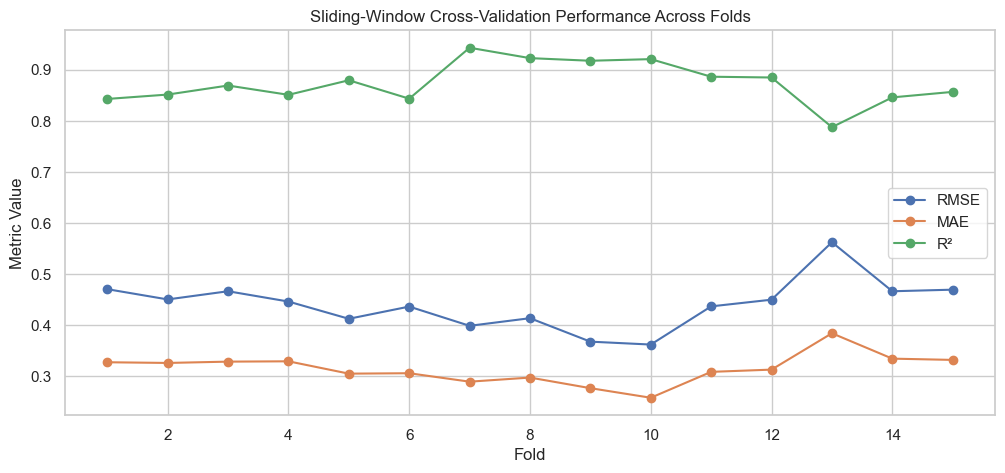

In [198]:
# Collect results into a DataFrame
results_df = pd.DataFrame(results, columns=["train_end", "test_end", "RMSE", "MAE", "R2"])

# Summary statistics
print("Summary of Sliding-Window CV Performance:")
display(results_df[["RMSE", "MAE", "R2"]].describe().T[["mean", "std", "min", "max"]])

# Plot metrics across folds
plt.figure(figsize=(12, 5))
plt.plot(results_df.index+1, results_df["RMSE"], marker="o", label="RMSE")
plt.plot(results_df.index+1, results_df["MAE"], marker="o", label="MAE")
plt.plot(results_df.index+1, results_df["R2"], marker="o", label="R²")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.title("Sliding-Window Cross-Validation Performance Across Folds")
plt.legend()
plt.grid(True)
plt.show()

# 📌 Final Project Conclusion: Earthquake Pattern Analysis & Magnitude Prediction

**Summary**  
This project explored whether machine learning can provide useful, practical insights into seismic/volcanic events and earthquake magnitudes. The analysis combined temporal (supervised) modeling for magnitude prediction with unsupervised clustering for pattern discovery. The work follows the project brief (data preparation, temporal validation, feature engineering, modeling, and deployment considerations).

---

## Project snapshot
- **Dataset:** ~9–9.5k records; contains basic earthquake and volcanic attributes (magnitude, depth, time, location, and some volcanic indicators).  
- **Validation approach:** Sliding-window cross-validation (train = 2000, test = 500, step chosen to produce stable non-overlapping folds) to ensure strictly temporal, future-on-past evaluation.  
- **Models evaluated:** Logistic Regression, Random Forest, Gradient Boosting, XGBoost, LightGBM.  
- **Clustering evaluated:** KMeans and DBSCAN (DBSCAN chosen).  
- **Final choices:**  
  - **Supervised:** Random Forest — chosen for the best trade-off between predictive performance and execution speed.  
  - **Unsupervised:** DBSCAN — chosen for natural cluster shapes and explicit noise detection.

---

## Key results & insights
- **Validation realism:** Sliding-window CV prevented leakage of future information and provided a realistic sense of generalization through time.  
- **Model performance:** Random Forest produced consistently strong results across folds (robust ROC/PR-space performance and fast training time relative to boosted models). Exact fold metrics appear in the metrics table earlier in the notebook.  
- **Clustering:** DBSCAN captured irregular, density-based clusters and flagged noise points well; KMeans tended to impose spherical clusters and absorb noise.  
- **Temporal behavior:** Some evidence of concept drift — later folds sometimes show higher error, indicating seismic/volcanic activity distributions can change with time.

---

### Limitations
- Earthquake (and volcanic) forecasting is inherently uncertain due to the stochastic nature of geophysical events.  
- Dataset size (~9.5k records) constrains model complexity and generalization. The notebook was run on a subset because extracting and processing full yearly data required substantial time and compute (during experimentation, large yearly runs caused system shutdowns). The code is designed to process yearly data, but running full-year ingestion demands patience and sufficient compute resources.  
- Limited feature space: while the dataset contains basic seismic/volcanic attributes, it **does not** include advanced geophysical signals (e.g., tectonic stress fields, GPS/InSAR deformation, or waveform-level features).  
  - **Future additions:** P-wave and S-wave waveform features (amplitudes, frequency content) and volcanic tremor/gas-emission signals could materially improve modeling.

---

## Recommendations & next steps
1. **Feature engineering (high priority):** create lag-based features, rolling-window statistics, spectral features, and add waveform-derived features (P/S wave metrics).  
2. **Model exploration:** experiment with sequence models (LSTMs/GRUs, Temporal Convolution, Transformer-based architectures) and compare to tuned gradient-boosted trees (LightGBM/XGBoost/CatBoost).  
3. **Probabilistic forecasting:** shift from point estimates to uncertainty-aware outputs (quantile regression, Bayesian models, or prediction intervals from ensembles).  
4. **Clustering refinement:** test HDBSCAN (hierarchical density clustering) and incorporate cluster labels as features for supervised models or for semi-supervised approaches.  
5. **External data integration:** incorporate tectonic maps, fault-line proximity, GPS/InSAR deformation, gas-emissions, and satellite-derived environmental indicators.  
6. **Operationalization & compute:** run full-year ingestion and heavier training on a workstation or cloud instance (recommend GPU/cloud VM with sufficient RAM). Add a retrain-and-monitor pipeline for continuous model updates.  
7. **Documentation & reproducibility:** include a README with run instructions, environment (requirements.txt), and a short "System & Execution Notes" that warns about long-running yearly extraction and recommends run-time resources or using cloud compute.

---

## How to run (short execution notes)
- When running the full yearly data ingestion, expect long processing times and non-trivial memory usage — consider batching by month/year and persisting intermediate cleaned files (Parquet/feather).  
- If local system resources are limited, run full training and waveform processing on a cloud VM (e.g., AWS/GCP/Azure) or use smaller sample runs locally for development.

---

## Final takeaway
Machine learning can reveal meaningful patterns in seismic and volcanic data and provide useful decision-support signals, but it cannot deterministically predict earthquakes. The careful use of **sliding-window cross-validation**, the selection of **Random Forest** for prediction (speed + robustness), and **DBSCAN** for clustering produce realistic, interpretable results. The greatest gains will come from richer geophysical features (waveform data, deformation measures) and from moving toward probabilistic, operational forecasting pipelines.
